## 1. Setup i Import Bibliotek

In [162]:
# Podstawowe biblioteki
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
import shap

# Scipy
from scipy.stats.mstats import winsorize

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

# XGBoost
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    print("⚠️  xgboost not installed")
    XGBOOST_AVAILABLE = False

# Konfiguracja
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)

print("✅ Biblioteki załadowane")
print(f"   XGBoost dostępny: {XGBOOST_AVAILABLE}")

✅ Biblioteki załadowane
   XGBoost dostępny: True


## 2. Wczytanie i Podział Danych

In [163]:
# Wczytanie danych
df = pd.read_csv("zbior_10.csv")
print(f"Wymiary: {df.shape}")
print(f"Klasa pozytywna: {100*df['default'].sum()/len(df):.2f}%")

# Podział train/test
df_train, df_test = train_test_split(df, test_size=0.3, random_state=1, stratify=df['default'])
X_train = df_train.drop("default", axis=1)
y_train = df_train["default"]
X_test = df_test.drop("default", axis=1)
y_test = df_test["default"]

print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")

Wymiary: (3000, 220)
Klasa pozytywna: 6.10%

Train: (2100, 219), Test: (900, 219)


## 3. Klasy Pipeline'ów

### 3.1 Funkcje Pomocnicze

In [164]:
def identify_columns_to_drop(X, missing_threshold=0.0, zero_threshold=0.90, keep_sparse_as_binary=True):
    """
    Identyfikuje kolumny do usunięcia lub transformacji binarnej.
    
    Zwraca:
        dict: Słownik z kategoryzacją kolumn
    """
    result = {
        'missing': [],
        'categorical': [],
        'low_variance': [],
        'constant': [],
        'sparse_to_binary': [],
        'to_drop': []
    }
    
    # Braki danych
    result['missing'] = X.columns[X.isna().sum() > missing_threshold * len(X)].tolist()
    
    # Kategoryczne
    result['categorical'] = X.select_dtypes(include=['object']).columns.tolist()
    
    # Numeryczne
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        if col in result['missing'] or col in result['categorical']:
            continue
            
        # Stałe
        if X[col].nunique() == 1:
            result['constant'].append(col)
            continue
        
        # Sparse (>90% zer)
        zero_pct = (X[col] == 0).sum() / len(X)
        if zero_pct > zero_threshold:
            if keep_sparse_as_binary:
                result['sparse_to_binary'].append(col)
            else:
                result['to_drop'].append(col)
            continue
        
        # Niska wariancja
        if X[col].nunique() <= 2:
            result['low_variance'].append(col)
    
    # Suma kolumn do usunięcia
    result['to_drop'].extend(result['missing'])
    result['to_drop'].extend(result['categorical'])
    result['to_drop'].extend(result['constant'])
    result['to_drop'].extend(result['low_variance'])
    
    return result


def calculate_winsorization_limits(X, lower_pct=0.01, upper_pct=0.99):
    """
    Oblicza limity winsoryzacji dla każdej kolumny na podstawie skośności.
    Ostrzejsza winsoryzacja z asymetrycznym obcinaniem:
    - Dane tylko dodatnie: winsoryzacja tylko od góry
    - Dane tylko ujemne: winsoryzacja tylko od dołu
    - Dane mieszane: winsoryzacja z obu stron
    """
    limits = {}
    for col in X.columns:
        skew = X[col].skew()
        col_min = X[col].min()
        col_max = X[col].max()
        has_negative = col_min < 0
        has_positive = col_max > 0
        
        # Winsoryzacja na podstawie skośności
        if abs(skew) > 3.0:
            cut = 0.07  # 7%
        elif abs(skew) > 2.0:
            cut = 0.05  # 5%
        elif abs(skew) > 1.0:
            cut = 0.03  # 3%
        elif abs(skew) > 0.5:
            cut = 0.02  # 2%
        else:
            cut = 0.01  # 1%
        
        # Asymetryczna winsoryzacja
        if has_positive and not has_negative:
            # Tylko dane dodatnie - obcinamy tylko od góry
            limits[col] = {
                'lower': col_min,  # Bez obcinania od dołu
                'upper': X[col].quantile(1 - cut)
            }
        elif has_negative and not has_positive:
            # Tylko dane ujemne - obcinamy tylko od dołu
            limits[col] = {
                'lower': X[col].quantile(cut),
                'upper': col_max  # Bez obcinania od góry
            }
        else:
            # Dane mieszane - obcinamy z obu stron
            limits[col] = {
                'lower': X[col].quantile(cut),
                'upper': X[col].quantile(1 - cut)
            }
    return limits

### 3.2 InterpretableColumnTransformer

In [165]:
class InterpretableColumnTransformer:
    """
    Transformer dla pojedynczej kolumny z odwracalnymi transformacjami.
    """
    
    def __init__(self, column_name):
        self.column_name = column_name
        self.method = None
        self.transformer = None
        self.scaler = StandardScaler()
        self.original_min = None
        self.original_max = None
        
    def fit(self, X, y=None):
        """
        Dopasowuje najlepszą transformację dla kolumny.
        """
        data = X.copy()
        self.original_min = data.min()
        self.original_max = data.max()
        
        # Standardowa standardyzacja jako fallback
        self.method = 'standard'
        self.scaler.fit(data.values.reshape(-1, 1))
        best_skew = np.abs(self.scaler.transform(data.values.reshape(-1, 1)).flatten()).mean()
        
        # Próbuj Box-Cox (wymaga wartości > 0)
        if (data > 0).all():
            try:
                transformer = PowerTransformer(method='box-cox', standardize=False)
                transformed = transformer.fit_transform(data.values.reshape(-1, 1)).flatten()
                skew = np.abs(pd.Series(transformed).skew())
                if skew < best_skew:
                    self.method = 'box-cox'
                    self.transformer = transformer
                    self.scaler.fit(transformed.reshape(-1, 1))
                    best_skew = skew
            except:
                pass
        
        # Próbuj Yeo-Johnson
        try:
            transformer = PowerTransformer(method='yeo-johnson', standardize=False)
            transformed = transformer.fit_transform(data.values.reshape(-1, 1)).flatten()
            skew = np.abs(pd.Series(transformed).skew())
            if skew < best_skew:
                self.method = 'yeo-johnson'
                self.transformer = transformer
                self.scaler.fit(transformed.reshape(-1, 1))
                best_skew = skew
        except:
            pass
        
        # Próbuj log1p
        if (data >= 0).all():
            try:
                transformed = np.log1p(data)
                skew = np.abs(transformed.skew())
                if skew < best_skew:
                    self.method = 'log1p'
                    self.transformer = None
                    self.scaler.fit(transformed.values.reshape(-1, 1))
            except:
                pass
        
        return self
    
    def transform(self, X):
        """
        Transformuje kolumnę.
        """
        data = X.copy()
        
        if self.method == 'box-cox' or self.method == 'yeo-johnson':
            data = self.transformer.transform(data.values.reshape(-1, 1)).flatten()
        elif self.method == 'log1p':
            data = np.log1p(data)
        
        # Standaryzacja
        std = self.scaler.scale_[0]
        if std > 1e-10:  # Zabezpieczenie przed dzieleniem przez 0
            data_transformed = self.scaler.transform(np.array(data).reshape(-1, 1)).flatten()
        else:
            data_transformed = np.zeros_like(data)
        
        return pd.Series(data_transformed, index=X.index)
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
    
    def inverse_transform(self, X):
        """
        Odwraca transformację.
        """
        data = self.scaler.inverse_transform(np.array(X).reshape(-1, 1)).flatten()
        
        if self.method == 'box-cox' or self.method == 'yeo-johnson':
            data = self.transformer.inverse_transform(data.reshape(-1, 1)).flatten()
        elif self.method == 'log1p':
            data = np.expm1(data)
        
        return pd.Series(data)

print("✅ InterpretableColumnTransformer zdefiniowany")

✅ InterpretableColumnTransformer zdefiniowany


### 3.3 Full Pipeline (InterpretablePreprocessingPipeline)

In [166]:
class InterpretablePreprocessingPipeline:
    """
    Pełny pipeline z transformacjami statystycznymi.
    """
    
    def __init__(self, correlation_threshold=0.8, keep_sparse_as_binary=True):
        self.correlation_threshold = correlation_threshold
        self.keep_sparse_as_binary = keep_sparse_as_binary
        self.columns_info = None
        self.winsorization_limits = None
        self.transformers = {}
        self.final_columns = None
        self.correlated_columns = None
        
    def fit(self, X, y=None):
        X_work = X.copy()
        
        # 1. Identyfikacja kolumn
        self.columns_info = identify_columns_to_drop(
            X_work, 
            keep_sparse_as_binary=self.keep_sparse_as_binary
        )
        
        # 2. Usunięcie problemowych kolumn
        X_work = X_work.drop(columns=self.columns_info['to_drop'], errors='ignore')
        
        # 3. Winsoryzacja
        numeric_cols = [c for c in X_work.columns if c not in self.columns_info['sparse_to_binary']]
        self.winsorization_limits = calculate_winsorization_limits(X_work[numeric_cols])
        
        for col in numeric_cols:
            X_work[col] = X_work[col].clip(
                lower=self.winsorization_limits[col]['lower'],
                upper=self.winsorization_limits[col]['upper']
            )
        
        # 4. Usuń wysoko skorelowane
        corr_matrix = X_work[numeric_cols].corr().abs()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.correlated_columns = [col for col in upper_tri.columns if any(upper_tri[col] > self.correlation_threshold)]
        X_work = X_work.drop(columns=self.correlated_columns)
        numeric_cols = [c for c in numeric_cols if c not in self.correlated_columns]
        
        # 5. Dopasuj transformery
        for col in numeric_cols:
            self.transformers[col] = InterpretableColumnTransformer(col)
            self.transformers[col].fit(X_work[col])
        
        self.final_columns = numeric_cols + self.columns_info['sparse_to_binary']
        return self
    
    def transform(self, X):
        X_work = X.copy()
        
        # Usuń kolumny
        X_work = X_work.drop(columns=self.columns_info['to_drop'], errors='ignore')
        X_work = X_work.drop(columns=self.correlated_columns, errors='ignore')
        
        # Winsoryzacja
        for col in self.transformers.keys():
            X_work[col] = X_work[col].clip(
                lower=self.winsorization_limits[col]['lower'],
                upper=self.winsorization_limits[col]['upper']
            )
        
        # Transformacje
        result = pd.DataFrame(index=X_work.index)
        for col in self.transformers.keys():
            result[col] = self.transformers[col].transform(X_work[col])
        
        # Binary dla sparse
        for col in self.columns_info['sparse_to_binary']:
            if col in X_work.columns:
                result[f"{col}_binary"] = (X_work[col] != 0).astype(int)
        
        return result
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

print("✅ InterpretablePreprocessingPipeline zdefiniowany")

✅ InterpretablePreprocessingPipeline zdefiniowany


### 3.4 Minimal Pipeline (MinimalPreprocessingPipeline)

In [167]:
class MinimalPreprocessingPipeline:
    """
    Minimalny pipeline - tylko winsoryzacja i standaryzacja.
    """
    
    def __init__(self, correlation_threshold=0.80, standardize=True):
        self.correlation_threshold = correlation_threshold
        self.standardize = standardize
        self.columns_to_drop = []
        self.correlated_columns = []
        self.winsorization_limits = None
        self.scaler = StandardScaler() if standardize else None
        self.final_columns = None
        
    def fit(self, X, y=None):
        X_work = X.copy()
        
        # 1. Usuń kategoryczne, NaN, stałe
        self.columns_to_drop = []
        self.columns_to_drop.extend(X_work.columns[X_work.isna().any()].tolist())
        self.columns_to_drop.extend(X_work.select_dtypes(include=['object']).columns.tolist())
        
        for col in X_work.select_dtypes(include=[np.number]).columns:
            if X_work[col].nunique() == 1:
                self.columns_to_drop.append(col)
        
        X_work = X_work.drop(columns=self.columns_to_drop, errors='ignore')
        
        # 2. Winsoryzacja
        self.winsorization_limits = calculate_winsorization_limits(X_work)
        for col in X_work.columns:
            X_work[col] = X_work[col].clip(
                lower=self.winsorization_limits[col]['lower'],
                upper=self.winsorization_limits[col]['upper']
            )
        
        # 3. Usuń skorelowane
        corr_matrix = X_work.corr().abs()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.correlated_columns = [col for col in upper_tri.columns if any(upper_tri[col] > self.correlation_threshold)]
        X_work = X_work.drop(columns=self.correlated_columns)
        
        # 4. Standaryzacja
        if self.standardize:
            self.scaler.fit(X_work)
        
        self.final_columns = X_work.columns.tolist()
        return self
    
    def transform(self, X):
        X_work = X.copy()
        
        # Usuń kolumny
        X_work = X_work.drop(columns=self.columns_to_drop, errors='ignore')
        X_work = X_work.drop(columns=self.correlated_columns, errors='ignore')
        
        # Winsoryzacja
        for col in X_work.columns:
            X_work[col] = X_work[col].clip(
                lower=self.winsorization_limits[col]['lower'],
                upper=self.winsorization_limits[col]['upper']
            )
        
        # Standaryzacja
        if self.standardize:
            X_transformed = self.scaler.transform(X_work)
            return pd.DataFrame(X_transformed, columns=self.final_columns, index=X_work.index)
        
        return X_work[self.final_columns]
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

print("✅ MinimalPreprocessingPipeline zdefiniowany")

✅ MinimalPreprocessingPipeline zdefiniowany


---

# CZĘŚĆ 1: FULL PIPELINE

## 4. Full Pipeline - Preprocessing

In [168]:
# Inicjalizacja i dopasowanie pipeline
pipeline_full = InterpretablePreprocessingPipeline(
    correlation_threshold=0.95,
    keep_sparse_as_binary=True
)

print("Dopasowywanie Full Pipeline...")
X_train_full = pipeline_full.fit_transform(X_train, y_train)
X_test_full = pipeline_full.transform(X_test)

print(f"\n✅ Full Pipeline gotowy")
print(f"   Train: {X_train_full.shape}")
print(f"   Test: {X_test_full.shape}")
print(f"   NaN: {X_train_full.isna().sum().sum()}")
print(f"   Inf: {np.isinf(X_train_full.values).sum()}")

Dopasowywanie Full Pipeline...



✅ Full Pipeline gotowy
   Train: (2100, 156)
   Test: (900, 156)
   NaN: 0
   Inf: 0


## 5. Full Pipeline - Trening Modeli

In [169]:
# Słownik do przechowywania wyników
results_full = {}

### 5.1 Logistic Regression (Full)

In [170]:
print("="*70)
print("LOGISTIC REGRESSION - FULL PIPELINE")
print("="*70)

lr_full = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_full.fit(X_train_full, y_train)

y_pred_lr_full = lr_full.predict(X_test_full)
y_proba_lr_full = lr_full.predict_proba(X_test_full)[:, 1]

results_full['LR'] = {
    'model': lr_full,
    'accuracy': accuracy_score(y_test, y_pred_lr_full),
    'precision': precision_score(y_test, y_pred_lr_full),
    'recall': recall_score(y_test, y_pred_lr_full),
    'f1': f1_score(y_test, y_pred_lr_full),
    'auc': roc_auc_score(y_test, y_proba_lr_full)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_full['LR']['accuracy']:.4f}")
print(f"  Precision: {results_full['LR']['precision']:.4f}")
print(f"  Recall:    {results_full['LR']['recall']:.4f}")
print(f"  F1-Score:  {results_full['LR']['f1']:.4f}")
print(f"  ROC-AUC:   {results_full['LR']['auc']:.4f}")

LOGISTIC REGRESSION - FULL PIPELINE

📊 Wyniki:
  Accuracy:  0.7500
  Precision: 0.1336
  Recall:    0.5636
  F1-Score:  0.2160
  ROC-AUC:   0.7379

📊 Wyniki:
  Accuracy:  0.7500
  Precision: 0.1336
  Recall:    0.5636
  F1-Score:  0.2160
  ROC-AUC:   0.7379


### 5.2 Decision Tree (Full)

In [171]:
print("="*70)
print("DECISION TREE - FULL PIPELINE")
print("="*70)

dt_full = DecisionTreeClassifier(
    max_depth=5, 
    min_samples_split=100, 
    min_samples_leaf=50,
    random_state=42, 
    class_weight='balanced'
)
dt_full.fit(X_train_full, y_train)

y_pred_dt_full = dt_full.predict(X_test_full)
y_proba_dt_full = dt_full.predict_proba(X_test_full)[:, 1]

results_full['DT'] = {
    'model': dt_full,
    'accuracy': accuracy_score(y_test, y_pred_dt_full),
    'precision': precision_score(y_test, y_pred_dt_full),
    'recall': recall_score(y_test, y_pred_dt_full),
    'f1': f1_score(y_test, y_pred_dt_full),
    'auc': roc_auc_score(y_test, y_proba_dt_full)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_full['DT']['accuracy']:.4f}")
print(f"  Precision: {results_full['DT']['precision']:.4f}")
print(f"  Recall:    {results_full['DT']['recall']:.4f}")
print(f"  F1-Score:  {results_full['DT']['f1']:.4f}")
print(f"  ROC-AUC:   {results_full['DT']['auc']:.4f}")

DECISION TREE - FULL PIPELINE

📊 Wyniki:
  Accuracy:  0.6911
  Precision: 0.1320
  Recall:    0.7273
  F1-Score:  0.2235
  ROC-AUC:   0.7362

📊 Wyniki:
  Accuracy:  0.6911
  Precision: 0.1320
  Recall:    0.7273
  F1-Score:  0.2235
  ROC-AUC:   0.7362


### 5.3 Naive Bayes (Full)

In [172]:
print("="*70)
print("NAIVE BAYES - FULL PIPELINE")
print("="*70)

nb_full = GaussianNB()
nb_full.fit(X_train_full, y_train)

y_pred_nb_full = nb_full.predict(X_test_full)
y_proba_nb_full = nb_full.predict_proba(X_test_full)[:, 1]

results_full['NB'] = {
    'model': nb_full,
    'accuracy': accuracy_score(y_test, y_pred_nb_full),
    'precision': precision_score(y_test, y_pred_nb_full),
    'recall': recall_score(y_test, y_pred_nb_full),
    'f1': f1_score(y_test, y_pred_nb_full),
    'auc': roc_auc_score(y_test, y_proba_nb_full)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_full['NB']['accuracy']:.4f}")
print(f"  Precision: {results_full['NB']['precision']:.4f}")
print(f"  Recall:    {results_full['NB']['recall']:.4f}")
print(f"  F1-Score:  {results_full['NB']['f1']:.4f}")
print(f"  ROC-AUC:   {results_full['NB']['auc']:.4f}")

NAIVE BAYES - FULL PIPELINE

📊 Wyniki:
  Accuracy:  0.2067
  Precision: 0.0693
  Recall:    0.9636
  F1-Score:  0.1293
  ROC-AUC:   0.5696


---

# CZĘŚĆ 1.5: MODELE BLACK BOX (FULL PIPELINE)

## 5.5 Modele Black Box - Słownik Wyników

In [173]:
# Słownik do przechowywania wyników modeli black box (Full Pipeline)
results_blackbox_full = {}

### 5.5.1 Random Forest (Black Box - Full)

In [174]:
print("="*70)
print("RANDOM FOREST - BLACK BOX (FULL PIPELINE)")
print("="*70)

rf_blackbox_full = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_blackbox_full.fit(X_train_full, y_train)

y_pred_rf_blackbox_full = rf_blackbox_full.predict(X_test_full)
y_proba_rf_blackbox_full = rf_blackbox_full.predict_proba(X_test_full)[:, 1]

results_blackbox_full['RF'] = {
    'model': rf_blackbox_full,
    'accuracy': accuracy_score(y_test, y_pred_rf_blackbox_full),
    'precision': precision_score(y_test, y_pred_rf_blackbox_full),
    'recall': recall_score(y_test, y_pred_rf_blackbox_full),
    'f1': f1_score(y_test, y_pred_rf_blackbox_full),
    'auc': roc_auc_score(y_test, y_proba_rf_blackbox_full)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_blackbox_full['RF']['accuracy']:.4f}")
print(f"  Precision: {results_blackbox_full['RF']['precision']:.4f}")
print(f"  Recall:    {results_blackbox_full['RF']['recall']:.4f}")
print(f"  F1-Score:  {results_blackbox_full['RF']['f1']:.4f}")
print(f"  ROC-AUC:   {results_blackbox_full['RF']['auc']:.4f}")

RANDOM FOREST - BLACK BOX (FULL PIPELINE)

📊 Wyniki:
  Accuracy:  0.8400
  Precision: 0.1752
  Recall:    0.4364
  F1-Score:  0.2500
  ROC-AUC:   0.7729

📊 Wyniki:
  Accuracy:  0.8400
  Precision: 0.1752
  Recall:    0.4364
  F1-Score:  0.2500
  ROC-AUC:   0.7729


### 5.5.2 XGBoost (Black Box - Full)

In [175]:
if XGBOOST_AVAILABLE:
    print("="*70)
    print("XGBOOST - BLACK BOX (FULL PIPELINE)")
    print("="*70)
    
    xgb_blackbox_full = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    # Oblicz scale_pos_weight dla class imbalance
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    xgb_blackbox_full.set_params(scale_pos_weight=scale_pos_weight)
    
    xgb_blackbox_full.fit(X_train_full, y_train)
    
    y_pred_xgb_blackbox_full = xgb_blackbox_full.predict(X_test_full)
    y_proba_xgb_blackbox_full = xgb_blackbox_full.predict_proba(X_test_full)[:, 1]
    
    results_blackbox_full['XGB'] = {
        'model': xgb_blackbox_full,
        'accuracy': accuracy_score(y_test, y_pred_xgb_blackbox_full),
        'precision': precision_score(y_test, y_pred_xgb_blackbox_full),
        'recall': recall_score(y_test, y_pred_xgb_blackbox_full),
        'f1': f1_score(y_test, y_pred_xgb_blackbox_full),
        'auc': roc_auc_score(y_test, y_proba_xgb_blackbox_full)
    }
    
    print(f"\n📊 Wyniki:")
    print(f"  Accuracy:  {results_blackbox_full['XGB']['accuracy']:.4f}")
    print(f"  Precision: {results_blackbox_full['XGB']['precision']:.4f}")
    print(f"  Recall:    {results_blackbox_full['XGB']['recall']:.4f}")
    print(f"  F1-Score:  {results_blackbox_full['XGB']['f1']:.4f}")
    print(f"  ROC-AUC:   {results_blackbox_full['XGB']['auc']:.4f}")
else:
    print("⚠️  XGBoost niedostępny")

XGBOOST - BLACK BOX (FULL PIPELINE)

📊 Wyniki:
  Accuracy:  0.9178
  Precision: 0.1935
  Recall:    0.1091
  F1-Score:  0.1395
  ROC-AUC:   0.7250

📊 Wyniki:
  Accuracy:  0.9178
  Precision: 0.1935
  Recall:    0.1091
  F1-Score:  0.1395
  ROC-AUC:   0.7250


### 5.5.3 SVM (Black Box - Full)

In [176]:
print("="*70)
print("SVM - BLACK BOX (FULL PIPELINE)")
print("="*70)

svm_blackbox_full = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    class_weight='balanced',
    probability=True  # Wymagane dla predict_proba
)
svm_blackbox_full.fit(X_train_full, y_train)

y_pred_svm_blackbox_full = svm_blackbox_full.predict(X_test_full)
y_proba_svm_blackbox_full = svm_blackbox_full.predict_proba(X_test_full)[:, 1]

results_blackbox_full['SVM'] = {
    'model': svm_blackbox_full,
    'accuracy': accuracy_score(y_test, y_pred_svm_blackbox_full),
    'precision': precision_score(y_test, y_pred_svm_blackbox_full),
    'recall': recall_score(y_test, y_pred_svm_blackbox_full),
    'f1': f1_score(y_test, y_pred_svm_blackbox_full),
    'auc': roc_auc_score(y_test, y_proba_svm_blackbox_full)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_blackbox_full['SVM']['accuracy']:.4f}")
print(f"  Precision: {results_blackbox_full['SVM']['precision']:.4f}")
print(f"  Recall:    {results_blackbox_full['SVM']['recall']:.4f}")
print(f"  F1-Score:  {results_blackbox_full['SVM']['f1']:.4f}")
print(f"  ROC-AUC:   {results_blackbox_full['SVM']['auc']:.4f}")

SVM - BLACK BOX (FULL PIPELINE)

📊 Wyniki:
  Accuracy:  0.8156
  Precision: 0.1465
  Recall:    0.4182
  F1-Score:  0.2170
  ROC-AUC:   0.7216

📊 Wyniki:
  Accuracy:  0.8156
  Precision: 0.1465
  Recall:    0.4182
  F1-Score:  0.2170
  ROC-AUC:   0.7216


### 5.5.4 Neural Network (Black Box - Full)

In [177]:
print("="*70)
print("NEURAL NETWORK (MLP) - BLACK BOX (FULL PIPELINE)")
print("="*70)

mlp_blackbox_full = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    verbose=False
)
mlp_blackbox_full.fit(X_train_full, y_train)

y_pred_mlp_blackbox_full = mlp_blackbox_full.predict(X_test_full)
y_proba_mlp_blackbox_full = mlp_blackbox_full.predict_proba(X_test_full)[:, 1]

results_blackbox_full['Neural Network'] = {
    'model': mlp_blackbox_full,
    'accuracy': accuracy_score(y_test, y_pred_mlp_blackbox_full),
    'precision': precision_score(y_test, y_pred_mlp_blackbox_full),
    'recall': recall_score(y_test, y_pred_mlp_blackbox_full),
    'f1': f1_score(y_test, y_pred_mlp_blackbox_full),
    'auc': roc_auc_score(y_test, y_proba_mlp_blackbox_full)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_blackbox_full['Neural Network']['accuracy']:.4f}")
print(f"  Precision: {results_blackbox_full['Neural Network']['precision']:.4f}")
print(f"  Recall:    {results_blackbox_full['Neural Network']['recall']:.4f}")
print(f"  F1-Score:  {results_blackbox_full['Neural Network']['f1']:.4f}")
print(f"  ROC-AUC:   {results_blackbox_full['Neural Network']['auc']:.4f}")
print(f"  Liczba iteracji: {mlp_blackbox_full.n_iter_}")
print(f"  Liczba warstw: {len(mlp_blackbox_full.hidden_layer_sizes)}")

NEURAL NETWORK (MLP) - BLACK BOX (FULL PIPELINE)

📊 Wyniki:
  Accuracy:  0.9389
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.5773
  Liczba iteracji: 22
  Liczba warstw: 3

📊 Wyniki:
  Accuracy:  0.9389
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.5773
  Liczba iteracji: 22
  Liczba warstw: 3


---

# CZĘŚĆ 2: MINIMAL PIPELINE

## 6. Minimal Pipeline - Preprocessing

In [178]:
# Inicjalizacja i dopasowanie pipeline
pipeline_minimal = MinimalPreprocessingPipeline(
    correlation_threshold=0.80,
    standardize=True
)

print("Dopasowywanie Minimal Pipeline...")
X_train_minimal = pipeline_minimal.fit_transform(X_train, y_train)
X_test_minimal = pipeline_minimal.transform(X_test)

print(f"\n✅ Minimal Pipeline gotowy")
print(f"   Train: {X_train_minimal.shape}")
print(f"   Test: {X_test_minimal.shape}")
print(f"   NaN: {X_train_minimal.isna().sum().sum()}")
print(f"   Inf: {np.isinf(X_train_minimal.values).sum()}")

Dopasowywanie Minimal Pipeline...

✅ Minimal Pipeline gotowy
   Train: (2100, 113)
   Test: (900, 113)
   NaN: 0
   Inf: 0

✅ Minimal Pipeline gotowy
   Train: (2100, 113)
   Test: (900, 113)
   NaN: 0
   Inf: 0


## 7. Minimal Pipeline - Trening Modeli

In [179]:
# Słownik do przechowywania wyników
results_minimal = {}

### 7.1 Logistic Regression (Minimal)

In [180]:
print("="*70)
print("LOGISTIC REGRESSION - MINIMAL PIPELINE")
print("="*70)

lr_minimal = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_minimal.fit(X_train_minimal, y_train)

y_pred_lr_minimal = lr_minimal.predict(X_test_minimal)
y_proba_lr_minimal = lr_minimal.predict_proba(X_test_minimal)[:, 1]

results_minimal['LR'] = {
    'model': lr_minimal,
    'accuracy': accuracy_score(y_test, y_pred_lr_minimal),
    'precision': precision_score(y_test, y_pred_lr_minimal),
    'recall': recall_score(y_test, y_pred_lr_minimal),
    'f1': f1_score(y_test, y_pred_lr_minimal),
    'auc': roc_auc_score(y_test, y_proba_lr_minimal)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_minimal['LR']['accuracy']:.4f}")
print(f"  Precision: {results_minimal['LR']['precision']:.4f}")
print(f"  Recall:    {results_minimal['LR']['recall']:.4f}")
print(f"  F1-Score:  {results_minimal['LR']['f1']:.4f}")
print(f"  ROC-AUC:   {results_minimal['LR']['auc']:.4f}")

LOGISTIC REGRESSION - MINIMAL PIPELINE

📊 Wyniki:
  Accuracy:  0.7022
  Precision: 0.1210
  Recall:    0.6182
  F1-Score:  0.2024
  ROC-AUC:   0.7132


### 7.2 Decision Tree (Minimal)

In [181]:
print("="*70)
print("DECISION TREE - MINIMAL PIPELINE")
print("="*70)

dt_minimal = DecisionTreeClassifier(
    max_depth=5, 
    min_samples_split=100, 
    min_samples_leaf=50,
    random_state=42, 
    class_weight='balanced'
)
dt_minimal.fit(X_train_minimal, y_train)

y_pred_dt_minimal = dt_minimal.predict(X_test_minimal)
y_proba_dt_minimal = dt_minimal.predict_proba(X_test_minimal)[:, 1]

results_minimal['DT'] = {
    'model': dt_minimal,
    'accuracy': accuracy_score(y_test, y_pred_dt_minimal),
    'precision': precision_score(y_test, y_pred_dt_minimal),
    'recall': recall_score(y_test, y_pred_dt_minimal),
    'f1': f1_score(y_test, y_pred_dt_minimal),
    'auc': roc_auc_score(y_test, y_proba_dt_minimal)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_minimal['DT']['accuracy']:.4f}")
print(f"  Precision: {results_minimal['DT']['precision']:.4f}")
print(f"  Recall:    {results_minimal['DT']['recall']:.4f}")
print(f"  F1-Score:  {results_minimal['DT']['f1']:.4f}")
print(f"  ROC-AUC:   {results_minimal['DT']['auc']:.4f}")

DECISION TREE - MINIMAL PIPELINE



📊 Wyniki:
  Accuracy:  0.5644
  Precision: 0.0860
  Recall:    0.6364
  F1-Score:  0.1515
  ROC-AUC:   0.6330


### 7.3 Naive Bayes (Minimal)

In [182]:
print("="*70)
print("NAIVE BAYES - MINIMAL PIPELINE")
print("="*70)

nb_minimal = GaussianNB()
nb_minimal.fit(X_train_minimal, y_train)

y_pred_nb_minimal = nb_minimal.predict(X_test_minimal)
y_proba_nb_minimal = nb_minimal.predict_proba(X_test_minimal)[:, 1]

results_minimal['NB'] = {
    'model': nb_minimal,
    'accuracy': accuracy_score(y_test, y_pred_nb_minimal),
    'precision': precision_score(y_test, y_pred_nb_minimal),
    'recall': recall_score(y_test, y_pred_nb_minimal),
    'f1': f1_score(y_test, y_pred_nb_minimal),
    'auc': roc_auc_score(y_test, y_proba_nb_minimal)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_minimal['NB']['accuracy']:.4f}")
print(f"  Precision: {results_minimal['NB']['precision']:.4f}")
print(f"  Recall:    {results_minimal['NB']['recall']:.4f}")
print(f"  F1-Score:  {results_minimal['NB']['f1']:.4f}")
print(f"  ROC-AUC:   {results_minimal['NB']['auc']:.4f}")

NAIVE BAYES - MINIMAL PIPELINE



📊 Wyniki:
  Accuracy:  0.5811
  Precision: 0.1073
  Recall:    0.8000
  F1-Score:  0.1892
  ROC-AUC:   0.7092


---

# CZĘŚĆ 2.5: MODELE BLACK BOX (MINIMAL PIPELINE)

## 7.5 Modele Black Box - Słownik Wyników

In [183]:
# Słownik do przechowywania wyników modeli black box
results_blackbox = {}

### 7.5.1 Random Forest (Black Box)

In [184]:
print("="*70)
print("RANDOM FOREST - BLACK BOX (MINIMAL PIPELINE)")
print("="*70)

rf_blackbox = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_blackbox.fit(X_train_minimal, y_train)

y_pred_rf_blackbox = rf_blackbox.predict(X_test_minimal)
y_proba_rf_blackbox = rf_blackbox.predict_proba(X_test_minimal)[:, 1]

results_blackbox['RF'] = {
    'model': rf_blackbox,
    'accuracy': accuracy_score(y_test, y_pred_rf_blackbox),
    'precision': precision_score(y_test, y_pred_rf_blackbox),
    'recall': recall_score(y_test, y_pred_rf_blackbox),
    'f1': f1_score(y_test, y_pred_rf_blackbox),
    'auc': roc_auc_score(y_test, y_proba_rf_blackbox)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_blackbox['RF']['accuracy']:.4f}")
print(f"  Precision: {results_blackbox['RF']['precision']:.4f}")
print(f"  Recall:    {results_blackbox['RF']['recall']:.4f}")
print(f"  F1-Score:  {results_blackbox['RF']['f1']:.4f}")
print(f"  ROC-AUC:   {results_blackbox['RF']['auc']:.4f}")

RANDOM FOREST - BLACK BOX (MINIMAL PIPELINE)

📊 Wyniki:
  Accuracy:  0.8267
  Precision: 0.1565
  Recall:    0.4182
  F1-Score:  0.2277
  ROC-AUC:   0.7558

📊 Wyniki:
  Accuracy:  0.8267
  Precision: 0.1565
  Recall:    0.4182
  F1-Score:  0.2277
  ROC-AUC:   0.7558


### 7.5.2 XGBoost (Black Box)

In [185]:
if XGBOOST_AVAILABLE:
    print("="*70)
    print("XGBOOST - BLACK BOX (MINIMAL PIPELINE)")
    print("="*70)
    
    xgb_blackbox = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    # Oblicz scale_pos_weight dla class imbalance
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    xgb_blackbox.set_params(scale_pos_weight=scale_pos_weight)
    
    xgb_blackbox.fit(X_train_minimal, y_train)
    
    y_pred_xgb_blackbox = xgb_blackbox.predict(X_test_minimal)
    y_proba_xgb_blackbox = xgb_blackbox.predict_proba(X_test_minimal)[:, 1]
    
    results_blackbox['XGB'] = {
        'model': xgb_blackbox,
        'accuracy': accuracy_score(y_test, y_pred_xgb_blackbox),
        'precision': precision_score(y_test, y_pred_xgb_blackbox),
        'recall': recall_score(y_test, y_pred_xgb_blackbox),
        'f1': f1_score(y_test, y_pred_xgb_blackbox),
        'auc': roc_auc_score(y_test, y_proba_xgb_blackbox)
    }
    
    print(f"\n📊 Wyniki:")
    print(f"  Accuracy:  {results_blackbox['XGB']['accuracy']:.4f}")
    print(f"  Precision: {results_blackbox['XGB']['precision']:.4f}")
    print(f"  Recall:    {results_blackbox['XGB']['recall']:.4f}")
    print(f"  F1-Score:  {results_blackbox['XGB']['f1']:.4f}")
    print(f"  ROC-AUC:   {results_blackbox['XGB']['auc']:.4f}")
else:
    print("⚠️  XGBoost niedostępny")

XGBOOST - BLACK BOX (MINIMAL PIPELINE)

📊 Wyniki:
  Accuracy:  0.9167
  Precision: 0.2222
  Recall:    0.1455
  F1-Score:  0.1758
  ROC-AUC:   0.7537

📊 Wyniki:
  Accuracy:  0.9167
  Precision: 0.2222
  Recall:    0.1455
  F1-Score:  0.1758
  ROC-AUC:   0.7537


### 7.5.3 SVM (Black Box - Minimal)

In [186]:
print("="*70)
print("SVM - BLACK BOX (MINIMAL PIPELINE)")
print("="*70)

svm_blackbox = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    class_weight='balanced',
    probability=True  # Wymagane dla predict_proba
)
svm_blackbox.fit(X_train_minimal, y_train)

y_pred_svm_blackbox = svm_blackbox.predict(X_test_minimal)
y_proba_svm_blackbox = svm_blackbox.predict_proba(X_test_minimal)[:, 1]

results_blackbox['SVM'] = {
    'model': svm_blackbox,
    'accuracy': accuracy_score(y_test, y_pred_svm_blackbox),
    'precision': precision_score(y_test, y_pred_svm_blackbox),
    'recall': recall_score(y_test, y_pred_svm_blackbox),
    'f1': f1_score(y_test, y_pred_svm_blackbox),
    'auc': roc_auc_score(y_test, y_proba_svm_blackbox)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_blackbox['SVM']['accuracy']:.4f}")
print(f"  Precision: {results_blackbox['SVM']['precision']:.4f}")
print(f"  Recall:    {results_blackbox['SVM']['recall']:.4f}")
print(f"  F1-Score:  {results_blackbox['SVM']['f1']:.4f}")
print(f"  ROC-AUC:   {results_blackbox['SVM']['auc']:.4f}")

SVM - BLACK BOX (MINIMAL PIPELINE)

📊 Wyniki:
  Accuracy:  0.8189
  Precision: 0.1351
  Recall:    0.3636
  F1-Score:  0.1970
  ROC-AUC:   0.7263

📊 Wyniki:
  Accuracy:  0.8189
  Precision: 0.1351
  Recall:    0.3636
  F1-Score:  0.1970
  ROC-AUC:   0.7263


### 7.5.4 Neural Network (Black Box - Minimal)

In [187]:
print("="*70)
print("NEURAL NETWORK (MLP) - BLACK BOX (MINIMAL PIPELINE)")
print("="*70)

mlp_blackbox = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    verbose=False
)
mlp_blackbox.fit(X_train_minimal, y_train)

y_pred_mlp_blackbox = mlp_blackbox.predict(X_test_minimal)
y_proba_mlp_blackbox = mlp_blackbox.predict_proba(X_test_minimal)[:, 1]

results_blackbox['Neural Network'] = {
    'model': mlp_blackbox,
    'accuracy': accuracy_score(y_test, y_pred_mlp_blackbox),
    'precision': precision_score(y_test, y_pred_mlp_blackbox),
    'recall': recall_score(y_test, y_pred_mlp_blackbox),
    'f1': f1_score(y_test, y_pred_mlp_blackbox),
    'auc': roc_auc_score(y_test, y_proba_mlp_blackbox)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_blackbox['Neural Network']['accuracy']:.4f}")
print(f"  Precision: {results_blackbox['Neural Network']['precision']:.4f}")
print(f"  Recall:    {results_blackbox['Neural Network']['recall']:.4f}")
print(f"  F1-Score:  {results_blackbox['Neural Network']['f1']:.4f}")
print(f"  ROC-AUC:   {results_blackbox['Neural Network']['auc']:.4f}")
print(f"  Liczba iteracji: {mlp_blackbox.n_iter_}")
print(f"  Liczba warstw: {len(mlp_blackbox.hidden_layer_sizes)}")

NEURAL NETWORK (MLP) - BLACK BOX (MINIMAL PIPELINE)

📊 Wyniki:
  Accuracy:  0.9389
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.5057
  Liczba iteracji: 22
  Liczba warstw: 3

📊 Wyniki:
  Accuracy:  0.9389
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.5057
  Liczba iteracji: 22
  Liczba warstw: 3


---

# CZĘŚĆ 3: PORÓWNANIE

## 8. Cross-Validation (Stratified K-Fold, 5 foldów)

In [188]:
print("="*110)
print("CROSS-VALIDATION NA DANYCH TRENINGOWYCH (Stratified K-Fold, 5 foldów)")
print("="*110)

# Inicjalizacja Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Słownik do przechowywania wyników CV
cv_results = {
    'Full Pipeline': {},
    'Minimal Pipeline': {},
    'Black Box (Full)': {},
    'Black Box (Minimal)': {}
}

print("\n🔄 Rozpoczynam cross-validation...\n")

# FULL PIPELINE - Modele interpretowalne
print("📊 Full Pipeline (Interpretable Models):")
for model_name, model_obj in [('LR', lr_full), ('DT', dt_full), ('NB', nb_full)]:
    scores = cross_val_score(model_obj, X_train_full, y_train, cv=skf, scoring='f1', n_jobs=-1)
    cv_results['Full Pipeline'][model_name] = {
        'scores': scores,
        'mean': scores.mean(),
        'std': scores.std()
    }
    print(f"  {model_name:3s}: {scores.mean():.4f} (+/- {scores.std():.4f}) | Foldy: {[f'{s:.4f}' for s in scores]}")

# MINIMAL PIPELINE - Modele interpretowalne
print("\n📊 Minimal Pipeline (Interpretable Models):")
for model_name, model_obj in [('LR', lr_minimal), ('DT', dt_minimal), ('NB', nb_minimal)]:
    scores = cross_val_score(model_obj, X_train_minimal, y_train, cv=skf, scoring='f1', n_jobs=-1)
    cv_results['Minimal Pipeline'][model_name] = {
        'scores': scores,
        'mean': scores.mean(),
        'std': scores.std()
    }
    print(f"  {model_name:3s}: {scores.mean():.4f} (+/- {scores.std():.4f}) | Foldy: {[f'{s:.4f}' for s in scores]}")

# BLACK BOX (FULL PIPELINE)
print("\n📊 Black Box (Full Pipeline):")
for model_name, model_obj in results_blackbox_full.items():
    scores = cross_val_score(model_obj['model'], X_train_full, y_train, cv=skf, scoring='f1', n_jobs=-1)
    cv_results['Black Box (Full)'][model_name] = {
        'scores': scores,
        'mean': scores.mean(),
        'std': scores.std()
    }
    print(f"  {model_name:15s}: {scores.mean():.4f} (+/- {scores.std():.4f}) | Foldy: {[f'{s:.4f}' for s in scores]}")

# BLACK BOX (MINIMAL PIPELINE)
print("\n📊 Black Box (Minimal Pipeline):")
for model_name, model_obj in results_blackbox.items():
    scores = cross_val_score(model_obj['model'], X_train_minimal, y_train, cv=skf, scoring='f1', n_jobs=-1)
    cv_results['Black Box (Minimal)'][model_name] = {
        'scores': scores,
        'mean': scores.mean(),
        'std': scores.std()
    }
    print(f"  {model_name:15s}: {scores.mean():.4f} (+/- {scores.std():.4f}) | Foldy: {[f'{s:.4f}' for s in scores]}")

print("\n" + "="*110)
print("✅ Cross-validation zakończony")
print("="*110)

CROSS-VALIDATION NA DANYCH TRENINGOWYCH (Stratified K-Fold, 5 foldów)

🔄 Rozpoczynam cross-validation...

📊 Full Pipeline (Interpretable Models):
  LR : 0.1867 (+/- 0.0091) | Foldy: ['0.1926', '0.2000', '0.1818', '0.1732', '0.1860']
  LR : 0.1867 (+/- 0.0091) | Foldy: ['0.1926', '0.2000', '0.1818', '0.1732', '0.1860']
  DT : 0.1549 (+/- 0.0344) | Foldy: ['0.1495', '0.1530', '0.1646', '0.1000', '0.2075']
  NB : 0.1227 (+/- 0.0059) | Foldy: ['0.1260', '0.1289', '0.1273', '0.1156', '0.1156']

📊 Minimal Pipeline (Interpretable Models):
  DT : 0.1549 (+/- 0.0344) | Foldy: ['0.1495', '0.1530', '0.1646', '0.1000', '0.2075']
  NB : 0.1227 (+/- 0.0059) | Foldy: ['0.1260', '0.1289', '0.1273', '0.1156', '0.1156']

📊 Minimal Pipeline (Interpretable Models):
  LR : 0.1774 (+/- 0.0183) | Foldy: ['0.1818', '0.1972', '0.1928', '0.1467', '0.1687']
  LR : 0.1774 (+/- 0.0183) | Foldy: ['0.1818', '0.1972', '0.1928', '0.1467', '0.1687']
  DT : 0.1574 (+/- 0.0120) | Foldy: ['0.1567', '0.1734', '0.1419', '0.

/home/wojtek/anaconda3/envs/ML/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [23:38:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/wojtek/anaconda3/envs/ML/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [23:38:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/wojtek/anaconda3/envs/ML/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [23:38:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/wojtek/anaconda3/envs/ML/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [23:38:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/wojtek/anacond

  XGB            : 0.0860 (+/- 0.0596) | Foldy: ['0.1026', '0.1143', '0.1714', '0.0000', '0.0417']
  SVM            : 0.1992 (+/- 0.0368) | Foldy: ['0.2093', '0.1852', '0.1591', '0.1772', '0.2653']
  SVM            : 0.1992 (+/- 0.0368) | Foldy: ['0.2093', '0.1852', '0.1591', '0.1772', '0.2653']
  Neural Network : 0.0000 (+/- 0.0000) | Foldy: ['0.0000', '0.0000', '0.0000', '0.0000', '0.0000']

📊 Black Box (Minimal Pipeline):
  Neural Network : 0.0000 (+/- 0.0000) | Foldy: ['0.0000', '0.0000', '0.0000', '0.0000', '0.0000']

📊 Black Box (Minimal Pipeline):
  RF             : 0.1756 (+/- 0.0442) | Foldy: ['0.2391', '0.1333', '0.1714', '0.1235', '0.2105']
  RF             : 0.1756 (+/- 0.0442) | Foldy: ['0.2391', '0.1333', '0.1714', '0.1235', '0.2105']


/home/wojtek/anaconda3/envs/ML/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [23:38:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/wojtek/anaconda3/envs/ML/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [23:38:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/wojtek/anaconda3/envs/ML/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [23:38:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/wojtek/anaconda3/envs/ML/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [23:38:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/wojtek/anacond

  XGB            : 0.0880 (+/- 0.0544) | Foldy: ['0.1176', '0.0541', '0.1143', '0.1538', '0.0000']
  SVM            : 0.1752 (+/- 0.0334) | Foldy: ['0.1505', '0.1720', '0.1474', '0.1667', '0.2393']
  SVM            : 0.1752 (+/- 0.0334) | Foldy: ['0.1505', '0.1720', '0.1474', '0.1667', '0.2393']
  Neural Network : 0.0000 (+/- 0.0000) | Foldy: ['0.0000', '0.0000', '0.0000', '0.0000', '0.0000']

✅ Cross-validation zakończony
  Neural Network : 0.0000 (+/- 0.0000) | Foldy: ['0.0000', '0.0000', '0.0000', '0.0000', '0.0000']

✅ Cross-validation zakończony


### 8.1 Wizualizacja wyników Cross-Validation

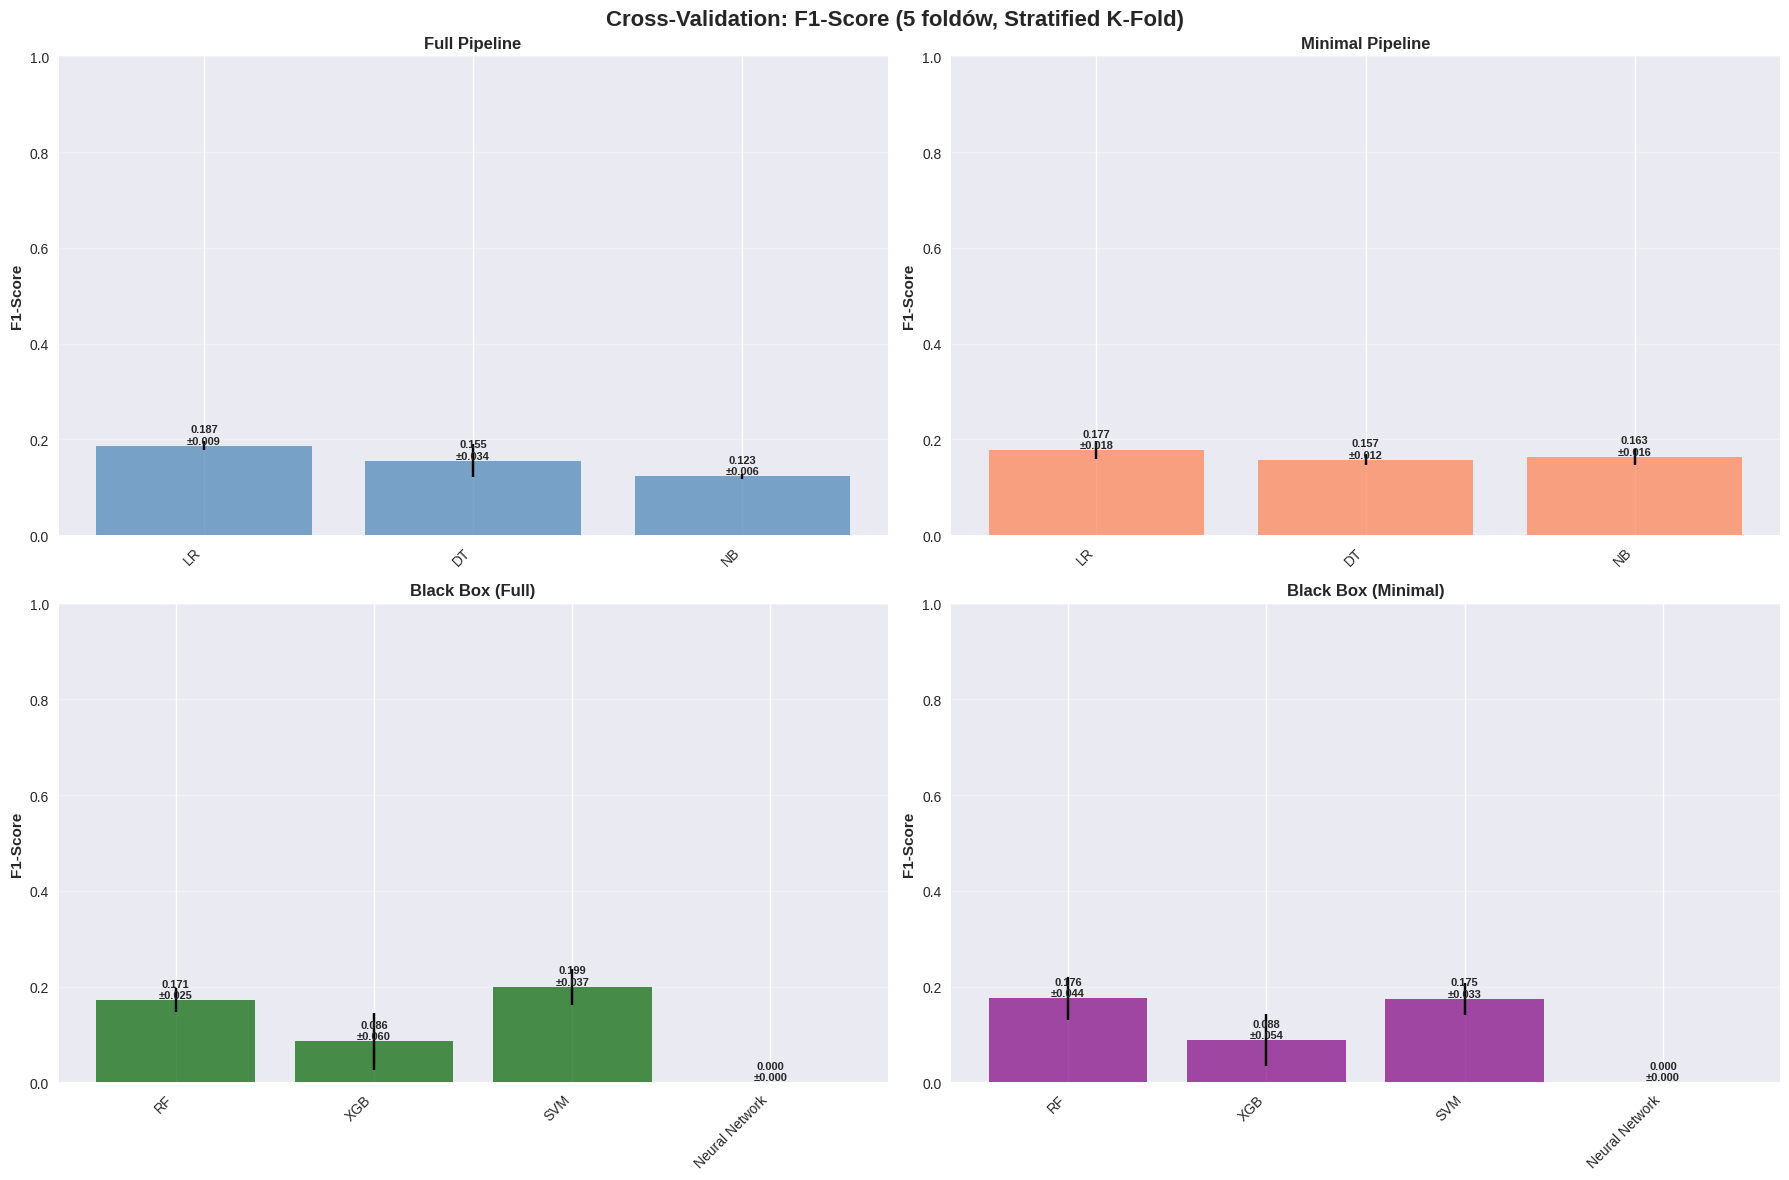


📈 Podsumowanie Cross-Validation:

Full Pipeline:
  Średnia F1-Score (wszystkie modele): 0.1548
  Najlepszy model: LR (0.1867 ± 0.0091)

Minimal Pipeline:
  Średnia F1-Score (wszystkie modele): 0.1659
  Najlepszy model: LR (0.1774 ± 0.0183)

Black Box (Full):
  Średnia F1-Score (wszystkie modele): 0.1141
  Najlepszy model: SVM (0.1992 ± 0.0368)

Black Box (Minimal):
  Średnia F1-Score (wszystkie modele): 0.1097
  Najlepszy model: RF (0.1756 ± 0.0442)



In [189]:
# Przygotowanie danych do wizualizacji
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Cross-Validation: F1-Score (5 foldów, Stratified K-Fold)', fontsize=16, fontweight='bold')

pipeline_configs = [
    ('Full Pipeline', cv_results['Full Pipeline'], axes[0, 0], 'steelblue'),
    ('Minimal Pipeline', cv_results['Minimal Pipeline'], axes[0, 1], 'coral'),
    ('Black Box (Full)', cv_results['Black Box (Full)'], axes[1, 0], 'darkgreen'),
    ('Black Box (Minimal)', cv_results['Black Box (Minimal)'], axes[1, 1], 'purple')
]

for pipeline_name, results, ax, color in pipeline_configs:
    model_names = list(results.keys())
    means = [results[m]['mean'] for m in model_names]
    stds = [results[m]['std'] for m in model_names]
    
    x_pos = np.arange(len(model_names))
    bars = ax.bar(x_pos, means, yerr=stds, alpha=0.7, color=color, capsize=5, ecolor='black')
    
    ax.set_ylabel('F1-Score', fontweight='bold')
    ax.set_title(pipeline_name, fontweight='bold', fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)
    
    # Dodaj wartości na słupkach
    for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{mean:.3f}\n±{std:.3f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# Podsumowanie statystyk
print("\n📈 Podsumowanie Cross-Validation:")
print("="*110)

for pipeline_name in ['Full Pipeline', 'Minimal Pipeline', 'Black Box (Full)', 'Black Box (Minimal)']:
    results = cv_results[pipeline_name]
    if results:
        avg_mean = np.mean([results[m]['mean'] for m in results.keys()])
        print(f"\n{pipeline_name}:")
        print(f"  Średnia F1-Score (wszystkie modele): {avg_mean:.4f}")
        best_model = max(results.keys(), key=lambda m: results[m]['mean'])
        print(f"  Najlepszy model: {best_model} ({results[best_model]['mean']:.4f} ± {results[best_model]['std']:.4f})")

print("\n" + "="*110)

## 9. Tabela Porównawcza

In [190]:
# Przygotowanie danych do porównania
comparison_data = []

for model_name in results_full.keys():
    # Full pipeline
    comparison_data.append({
        'Pipeline': 'Full',
        'Model': model_name,
        'Accuracy': results_full[model_name]['accuracy'],
        'Precision': results_full[model_name]['precision'],
        'Recall': results_full[model_name]['recall'],
        'F1-Score': results_full[model_name]['f1'],
        'ROC-AUC': results_full[model_name]['auc']
    })
    
    # Minimal pipeline
    if model_name in results_minimal:
        comparison_data.append({
            'Pipeline': 'Minimal',
            'Model': model_name,
            'Accuracy': results_minimal[model_name]['accuracy'],
            'Precision': results_minimal[model_name]['precision'],
            'Recall': results_minimal[model_name]['recall'],
            'F1-Score': results_minimal[model_name]['f1'],
            'ROC-AUC': results_minimal[model_name]['auc']
        })

# Dodaj modele black box (Full Pipeline)
for model_name in results_blackbox_full.keys():
    comparison_data.append({
        'Pipeline': 'Black Box (Full)',
        'Model': model_name,
        'Accuracy': results_blackbox_full[model_name]['accuracy'],
        'Precision': results_blackbox_full[model_name]['precision'],
        'Recall': results_blackbox_full[model_name]['recall'],
        'F1-Score': results_blackbox_full[model_name]['f1'],
        'ROC-AUC': results_blackbox_full[model_name]['auc']
    })

# Dodaj modele black box (Minimal Pipeline)
for model_name in results_blackbox.keys():
    comparison_data.append({
        'Pipeline': 'Black Box (Minimal)',
        'Model': model_name,
        'Accuracy': results_blackbox[model_name]['accuracy'],
        'Precision': results_blackbox[model_name]['precision'],
        'Recall': results_blackbox[model_name]['recall'],
        'F1-Score': results_blackbox[model_name]['f1'],
        'ROC-AUC': results_blackbox[model_name]['auc']
    })

comparison_df = pd.DataFrame(comparison_data)

print("="*110)
print("PORÓWNANIE WSZYSTKICH MODELI - FULL vs MINIMAL vs BLACK BOX (Full & Minimal)")
print("="*110)
print()
print(comparison_df.to_string(index=False))
print()
print(f"\n🔢 Liczba cech:")
print(f"   Full Pipeline:         {X_train_full.shape[1]} cech")
print(f"   Minimal Pipeline:      {X_train_minimal.shape[1]} cech")
print(f"   Black Box (Full):      {X_train_full.shape[1]} cech (używa Full Pipeline)")
print(f"   Black Box (Minimal):   {X_train_minimal.shape[1]} cech (używa Minimal Pipeline)")

PORÓWNANIE WSZYSTKICH MODELI - FULL vs MINIMAL vs BLACK BOX (Full & Minimal)

           Pipeline          Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
               Full             LR  0.750000   0.133621 0.563636  0.216028 0.737945
            Minimal             LR  0.702222   0.120996 0.618182  0.202381 0.713222
               Full             DT  0.691111   0.132013 0.727273  0.223464 0.736202
            Minimal             DT  0.564444   0.085995 0.636364  0.151515 0.632964
               Full             NB  0.206667   0.069281 0.963636  0.129268 0.569575
            Minimal             NB  0.581111   0.107317 0.800000  0.189247 0.709220
   Black Box (Full)             RF  0.840000   0.175182 0.436364  0.250000 0.772932
   Black Box (Full)            XGB  0.917778   0.193548 0.109091  0.139535 0.724970
   Black Box (Full)            SVM  0.815556   0.146497 0.418182  0.216981 0.721592
   Black Box (Full) Neural Network  0.938889   0.000000 0.000000  0.000000 0.57734

## 10. Wizualizacje Porównawcze

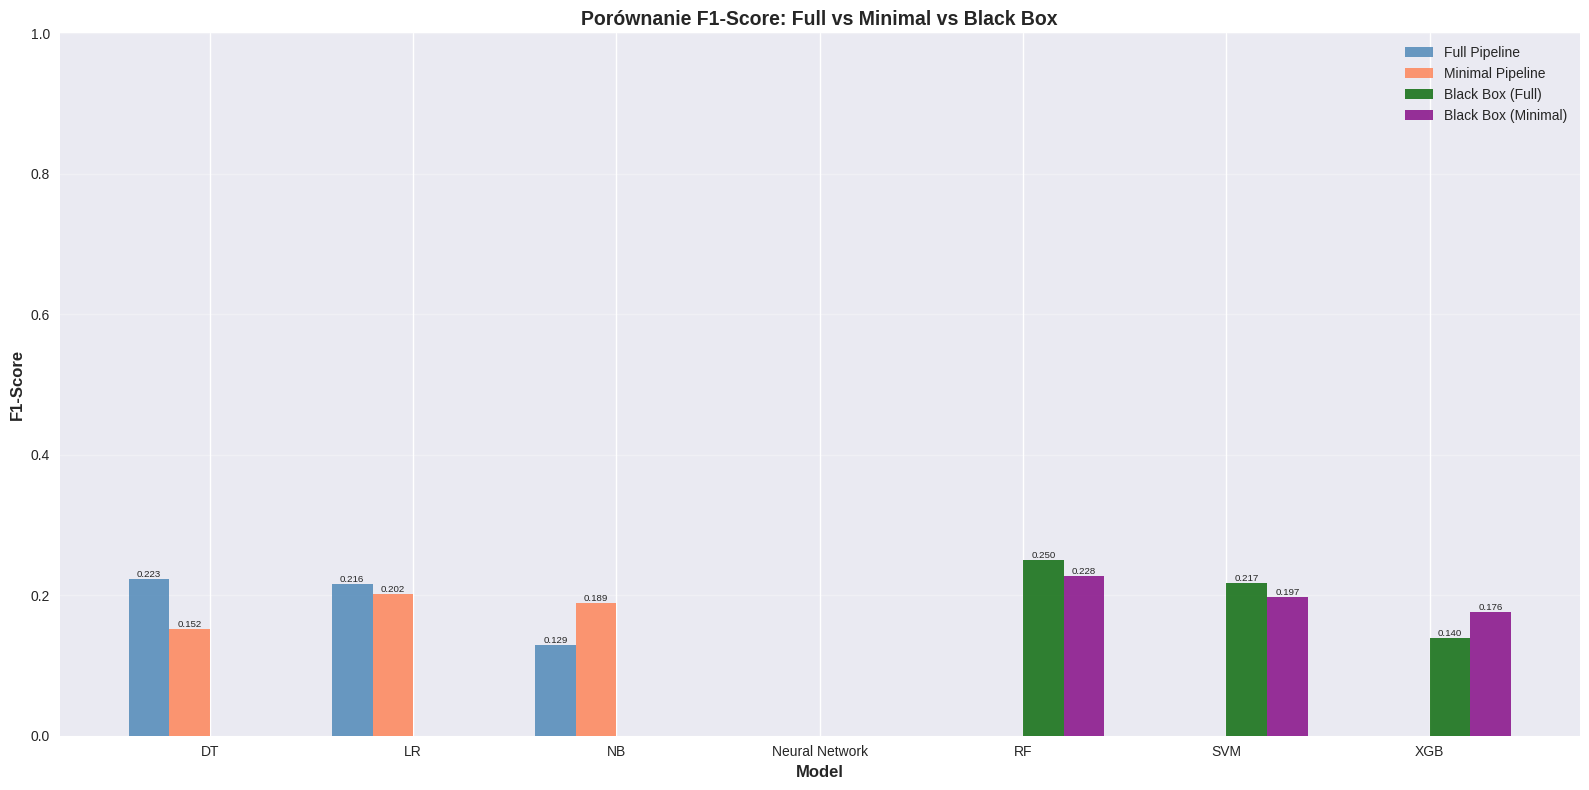


📈 Średnie F1-Score:
   Full Pipeline (Interpretable):       0.1896
   Minimal Pipeline (Interpretable):    0.1810
   Black Box (Full Pipeline):           0.1516
   Black Box (Minimal Pipeline):        0.1501

📊 Różnice:
   Full vs Minimal:                     +0.0085
   Black Box (Full) vs Full:            -0.0380
   Black Box (Minimal) vs Minimal:      -0.0309

✅ Najlepszy średni wynik: Full (Interpretable) (0.1896)


In [191]:
# Wykres słupkowy F1-Score
fig, ax = plt.subplots(figsize=(16, 8))

# Przygotuj dane - wszystkie unikalne modele
all_model_names = sorted(set(list(results_full.keys()) + list(results_blackbox_full.keys()) + list(results_blackbox.keys())))

full_f1s = [results_full[m]['f1'] if m in results_full else 0 for m in all_model_names]
minimal_f1s = [results_minimal[m]['f1'] if m in results_minimal else 0 for m in all_model_names]
blackbox_full_f1s = [results_blackbox_full[m]['f1'] if m in results_blackbox_full else 0 for m in all_model_names]
blackbox_minimal_f1s = [results_blackbox[m]['f1'] if m in results_blackbox else 0 for m in all_model_names]

x = np.arange(len(all_model_names))
width = 0.2

bars1 = ax.bar(x - 1.5*width, full_f1s, width, label='Full Pipeline', color='steelblue', alpha=0.8)
bars2 = ax.bar(x - 0.5*width, minimal_f1s, width, label='Minimal Pipeline', color='coral', alpha=0.8)
bars3 = ax.bar(x + 0.5*width, blackbox_full_f1s, width, label='Black Box (Full)', color='darkgreen', alpha=0.8)
bars4 = ax.bar(x + 1.5*width, blackbox_minimal_f1s, width, label='Black Box (Minimal)', color='purple', alpha=0.8)

ax.set_xlabel('Model', fontweight='bold', fontsize=12)
ax.set_ylabel('F1-Score', fontweight='bold', fontsize=12)
ax.set_title('Porównanie F1-Score: Full vs Minimal vs Black Box', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(all_model_names)
ax.legend(fontsize=10, loc='best')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.0, 1.0])

# Wartości na słupkach
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        if height > 0.01:  # Tylko dla niepustych słupków
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=7, rotation=0)

plt.tight_layout()
plt.show()

# Statystyki
interpretable_f1s = [results_full[m]['f1'] for m in results_full.keys()]
minimal_all_f1s = [results_minimal[m]['f1'] for m in results_minimal.keys()]
blackbox_full_all_f1s = [results_blackbox_full[m]['f1'] for m in results_blackbox_full.keys()]
blackbox_minimal_all_f1s = [results_blackbox[m]['f1'] for m in results_blackbox.keys()]

avg_full = np.mean(interpretable_f1s)
avg_minimal = np.mean(minimal_all_f1s)
avg_blackbox_full = np.mean(blackbox_full_all_f1s) if blackbox_full_all_f1s else 0
avg_blackbox_minimal = np.mean(blackbox_minimal_all_f1s) if blackbox_minimal_all_f1s else 0

print(f"\n📈 Średnie F1-Score:")
print(f"   Full Pipeline (Interpretable):       {avg_full:.4f}")
print(f"   Minimal Pipeline (Interpretable):    {avg_minimal:.4f}")
if blackbox_full_all_f1s:
    print(f"   Black Box (Full Pipeline):           {avg_blackbox_full:.4f}")
if blackbox_minimal_all_f1s:
    print(f"   Black Box (Minimal Pipeline):        {avg_blackbox_minimal:.4f}")

print(f"\n📊 Różnice:")
print(f"   Full vs Minimal:                     {avg_full - avg_minimal:+.4f}")
if blackbox_full_all_f1s:
    print(f"   Black Box (Full) vs Full:            {avg_blackbox_full - avg_full:+.4f}")
if blackbox_minimal_all_f1s:
    print(f"   Black Box (Minimal) vs Minimal:      {avg_blackbox_minimal - avg_minimal:+.4f}")

# Najlepszy model
pipelines_to_compare = [
    ('Full (Interpretable)', avg_full),
    ('Minimal (Interpretable)', avg_minimal),
]
if blackbox_full_all_f1s:
    pipelines_to_compare.append(('Black Box (Full)', avg_blackbox_full))
if blackbox_minimal_all_f1s:
    pipelines_to_compare.append(('Black Box (Minimal)', avg_blackbox_minimal))

best_pipeline = max(pipelines_to_compare, key=lambda x: x[1])

print(f"\n✅ Najlepszy średni wynik: {best_pipeline[0]} ({best_pipeline[1]:.4f})")

## 11. Wnioski

**Porównanie zostało zakończone!**

Ten notebook porównał cztery kategorie modeli:
- **Full Pipeline (Interpretable)**: LR, DT, NB z pełnymi transformacjami statystycznymi
- **Minimal Pipeline (Interpretable)**: LR, DT, NB z minimalnym preprocessingiem
- **Black Box (Full Pipeline)**: Random Forest, XGBoost, SVM i Neural Network z pełnymi transformacjami
- **Black Box (Minimal Pipeline)**: Random Forest, XGBoost, SVM i Neural Network z minimalnym preprocessingiem

Sprawdź wyniki powyżej, aby określić:
1. Czy złożone transformacje poprawiają wyniki modeli interpretowalnych
2. Jak modele black box wypadają w porównaniu do modeli interpretowalnych
3. Czy black box modele bardziej korzystają z Full czy Minimal Pipeline
4. Która strategia oferuje najlepszy kompromis między interpretowalnością a wydajnością
5. Jak cross-validation potwierdza stabilność wyników modeli

## 12. Feature Importance z SHAP (Full Pipeline: LR, DT, RF)

Analiza ważności cech przy użyciu biblioteki SHAP dla pełnego pipeline'u.

In [192]:
# SHAP Full Pipeline (LR, DT, RF)
print("="*100)
print("SHAP Feature Importance - Full Pipeline (LR, DT, RF)")
print("="*100)

try:
    import shap
    SHAP_AVAILABLE_FULL = True
except ImportError:
    SHAP_AVAILABLE_FULL = False
    print("⚠️  Brak biblioteki 'shap' (pip install shap)")

full_top30_features = []
shap_full_df = None

if SHAP_AVAILABLE_FULL:
    # Przygotowanie losowej próbki danych treningowych
    sample_size = min(1000, len(X_train_full))
    X_sample_full = X_train_full.sample(n=sample_size, random_state=42)
    
    shap_results_full = []
    
    # 1. LOGISTIC REGRESSION (Full)
    print("\n[1/3] Obliczanie SHAP dla Logistic Regression (Full)...")
    explainer_lr_full = shap.LinearExplainer(lr_full, X_sample_full)
    shap_values_lr_full = explainer_lr_full.shap_values(X_sample_full)
    
    # Jeśli jest to klasyfikacja binarna i shap_values to lista
    if type(shap_values_lr_full) == list:
        shap_values_lr_full = shap_values_lr_full[1]
    
    shap_abs_mean_lr_full = np.abs(shap_values_lr_full).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_full.columns):
        shap_results_full.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_lr_full[i],
            'model': 'LR'
        })
    
    # 2. DECISION TREE (Full)
    print("[2/3] Obliczanie SHAP dla Decision Tree (Full)...")
    explainer_dt_full = shap.TreeExplainer(dt_full)
    shap_values_dt_full = explainer_dt_full.shap_values(X_sample_full)
    
    if type(shap_values_dt_full) == list:
        shap_values_dt_full = shap_values_dt_full[1]
    
    shap_abs_mean_dt_full = np.abs(shap_values_dt_full).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_full.columns):
        shap_results_full.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_dt_full[i],
            'model': 'DT'
        })
    
    # 3. RANDOM FOREST (Full)
    print("[3/3] Obliczanie SHAP dla Random Forest (Full)...")
    explainer_rf_full = shap.TreeExplainer(rf_blackbox_full)
    shap_values_rf_full = explainer_rf_full.shap_values(X_sample_full)
    
    if type(shap_values_rf_full) == list:
        shap_values_rf_full = shap_values_rf_full[1]
    
    shap_abs_mean_rf_full = np.abs(shap_values_rf_full).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_full.columns):
        shap_results_full.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_rf_full[i],
            'model': 'RF'
        })
    
    # Agregacja wyników - średnia z LR, DT i RF
    shap_full_df = pd.DataFrame(shap_results_full)
    shap_full_agg = shap_full_df.groupby('feature')['SHAP_mean'].mean().reset_index()
    print(shap_full_agg['SHAP_mean'].head())

    shap_full_agg['SHAP_mean'] = shap_full_agg['SHAP_mean'].apply(
        lambda x: float(np.mean(x)) if isinstance(x, (list, np.ndarray)) else float(x)
    )
    shap_full_agg = shap_full_agg.sort_values('SHAP_mean', ascending=False)
    
    full_top30_features = shap_full_agg.head(30)['feature'].tolist()
    
    print("\n✅ Obliczenia SHAP zakończone (Full Pipeline).")
    print(f"Top 30 cech: {len(full_top30_features)} cech wybranych.")
else:
    print("⚠️ SHAP niedostępny - pomiń ten krok lub zainstaluj: pip install shap")

SHAP Feature Importance - Full Pipeline (LR, DT, RF)

[1/3] Obliczanie SHAP dla Logistic Regression (Full)...
[2/3] Obliczanie SHAP dla Decision Tree (Full)...
[3/3] Obliczanie SHAP dla Random Forest (Full)...
0      [0.04413810325996944, 0.04413810325996944]
1      [0.05444317205617616, 0.05444317205617616]
2        [0.4501251642917919, 0.4501251642917919]
3    [0.013472943381230154, 0.013472943381230154]
4    [0.029943020349809998, 0.029943020349809998]
Name: SHAP_mean, dtype: object

✅ Obliczenia SHAP zakończone (Full Pipeline).
Top 30 cech: 30 cech wybranych.
0      [0.04413810325996944, 0.04413810325996944]
1      [0.05444317205617616, 0.05444317205617616]
2        [0.4501251642917919, 0.4501251642917919]
3    [0.013472943381230154, 0.013472943381230154]
4    [0.029943020349809998, 0.029943020349809998]
Name: SHAP_mean, dtype: object

✅ Obliczenia SHAP zakończone (Full Pipeline).
Top 30 cech: 30 cech wybranych.


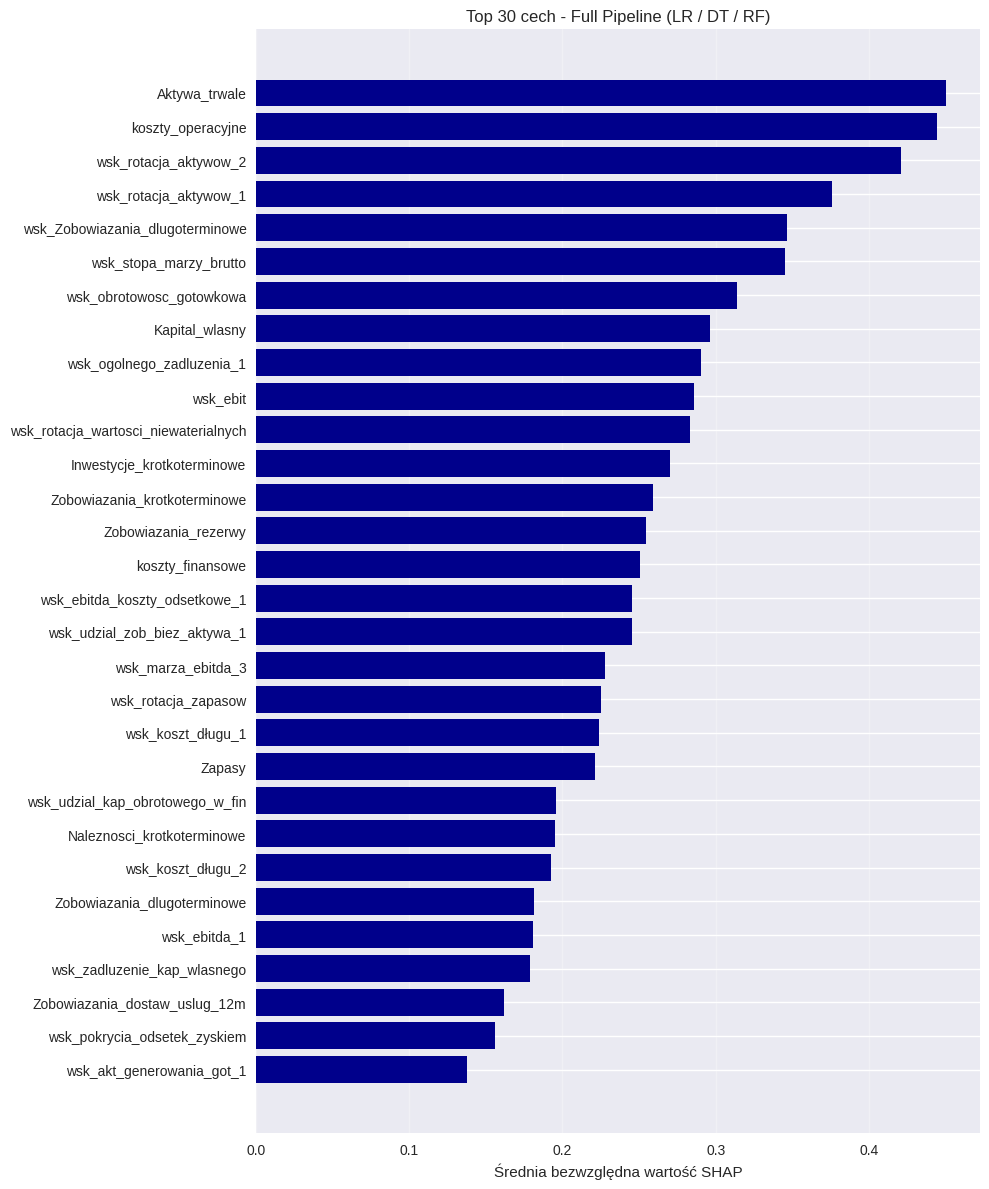

In [193]:
# Wykres Top 30 Full Pipeline
if shap_full_df is not None and len(full_top30_features) > 0:
    plot_df_full = shap_full_agg.head(30)
    plt.figure(figsize=(10,12))
    plt.barh(plot_df_full['feature'][::-1], plot_df_full['SHAP_mean'][::-1], color='darkblue')
    plt.xlabel('Średnia bezwzględna wartość SHAP')
    plt.title('Top 30 cech - Full Pipeline (LR / DT / RF)')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ Brak danych do wykresu Full Pipeline SHAP.')

## 13. Feature Importance z SHAP (Minimal Pipeline: LR, DT, RF)

Analiza ważności cech przy użyciu biblioteki SHAP dla minimalnego pipeline'u.

In [194]:
# SHAP Minimal Pipeline (LR, DT, RF)
print("="*100)
print("SHAP Feature Importance - Minimal Pipeline (LR, DT, RF)")
print("="*100)

try:
    import shap
    SHAP_AVAILABLE_MIN = True
except ImportError:
    SHAP_AVAILABLE_MIN = False
    print("⚠️  Brak biblioteki 'shap' (pip install shap)")

minimal_top30_features = []
shap_min_df = None

if SHAP_AVAILABLE_MIN:
    # Przygotowanie losowej próbki danych treningowych
    sample_size = min(1000, len(X_train_minimal))
    X_sample_min = X_train_minimal.sample(n=sample_size, random_state=42)
    
    shap_results_min = []
    
    # 1. LOGISTIC REGRESSION (Minimal)
    print("\n[1/3] Obliczanie SHAP dla Logistic Regression (Minimal)...")
    explainer_lr_min = shap.LinearExplainer(lr_minimal, X_sample_min)
    shap_values_lr_min = explainer_lr_min.shap_values(X_sample_min)
    
    # Jeśli jest to klasyfikacja binarna i shap_values to lista
    if type(shap_values_lr_min) == list:
        shap_values_lr_min = shap_values_lr_min[1]
    
    shap_abs_mean_lr_min = np.abs(shap_values_lr_min).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_min.columns):
        shap_results_min.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_lr_min[i],
            'model': 'LR'
        })
    
    # 2. DECISION TREE (Minimal)
    print("[2/3] Obliczanie SHAP dla Decision Tree (Minimal)...")
    explainer_dt_min = shap.TreeExplainer(dt_minimal)
    shap_values_dt_min = explainer_dt_min.shap_values(X_sample_min)
    
    if type(shap_values_dt_min) == list:
        shap_values_dt_min = shap_values_dt_min[1]
    
    shap_abs_mean_dt_min = np.abs(shap_values_dt_min).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_min.columns):
        shap_results_min.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_dt_min[i],
            'model': 'DT'
        })
    
    # 3. RANDOM FOREST (Minimal)
    print("[3/3] Obliczanie SHAP dla Random Forest (Minimal)...")
    explainer_rf_min = shap.TreeExplainer(rf_blackbox)
    shap_values_rf_min = explainer_rf_min.shap_values(X_sample_min)
    
    if type(shap_values_rf_min) == list:
        shap_values_rf_min = shap_values_rf_min[1]
    
    shap_abs_mean_rf_min = np.abs(shap_values_rf_min).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_min.columns):
        shap_results_min.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_rf_min[i],
            'model': 'RF'
        })
    
    # Agregacja wyników - średnia z LR, DT i RF
    shap_min_df = pd.DataFrame(shap_results_min)
    shap_min_agg = shap_min_df.groupby('feature')['SHAP_mean'].mean().reset_index()
    shap_min_agg['SHAP_mean'] = shap_min_agg['SHAP_mean'].apply(
    lambda x: float(np.mean(x)) if isinstance(x, (list, np.ndarray)) else float(x)
)
    shap_min_agg = shap_min_agg.sort_values('SHAP_mean', ascending=False)
    
    minimal_top30_features = shap_min_agg.head(30)['feature'].tolist()
    
    print("\n✅ Obliczenia SHAP zakończone (Minimal Pipeline).")
    print(f"Top 30 cech: {len(minimal_top30_features)} cech wybranych.")
else:
    print("⚠️ SHAP niedostępny - pomiń ten krok lub zainstaluj: pip install shap")

SHAP Feature Importance - Minimal Pipeline (LR, DT, RF)

[1/3] Obliczanie SHAP dla Logistic Regression (Minimal)...
[2/3] Obliczanie SHAP dla Decision Tree (Minimal)...
[3/3] Obliczanie SHAP dla Random Forest (Minimal)...

✅ Obliczenia SHAP zakończone (Minimal Pipeline).
Top 30 cech: 30 cech wybranych.

✅ Obliczenia SHAP zakończone (Minimal Pipeline).
Top 30 cech: 30 cech wybranych.


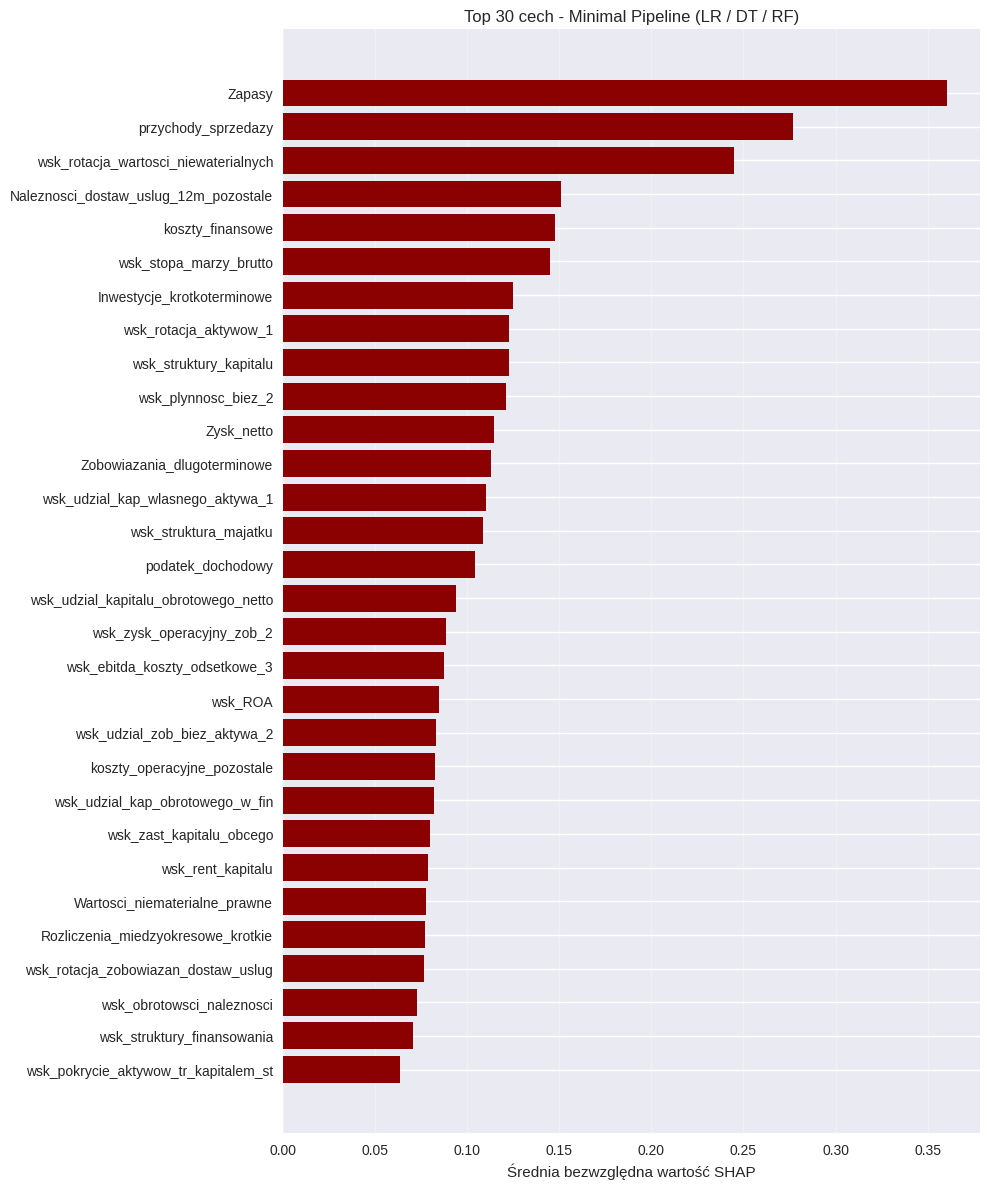

In [195]:
# Wykres Top 30 Minimal Pipeline
if shap_min_df is not None and len(minimal_top30_features) > 0:
    plot_df_min = shap_min_agg.head(30)
    plt.figure(figsize=(10,12))
    plt.barh(plot_df_min['feature'][::-1], plot_df_min['SHAP_mean'][::-1], color='darkred')
    plt.xlabel('Średnia bezwzględna wartość SHAP')
    plt.title('Top 30 cech - Minimal Pipeline (LR / DT / RF)')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ Brak danych do wykresu Minimal Pipeline SHAP.')

## 14. Modele na Top 30 cechach (Full Pipeline)

Trening modeli Logistic Regression, Decision Tree i Random Forest na 30 najważniejszych cechach wybranych przez SHAP dla pełnego pipeline'u.

In [196]:
# Modele na Top 30 cechach - Full Pipeline
print("="*100)
print("TRENOWANIE MODELI NA TOP 30 CECHACH - FULL PIPELINE")
print("="*100)

if len(full_top30_features) > 0:
    # Wybór tylko top 30 cech
    X_train_full_top30 = X_train_full[full_top30_features]
    X_test_full_top30 = X_test_full[full_top30_features]
    
    print(f"\nWybrano {len(full_top30_features)} cech z {X_train_full.shape[1]} dostępnych.")
    print(f"Kształt danych treningowych: {X_train_full_top30.shape}")
    print(f"Kształt danych testowych: {X_test_full_top30.shape}")
    
    results_full_top30 = {}
    
    # 1. LOGISTIC REGRESSION
    print("\n[1/3] Trening Logistic Regression na Top 30 cechach (Full)...")
    lr_full_top30 = LogisticRegression(max_iter=1000, random_state=42)
    lr_full_top30.fit(X_train_full_top30, y_train)
    y_pred_lr_full_top30 = lr_full_top30.predict(X_test_full_top30)
    y_proba_lr_full_top30 = lr_full_top30.predict_proba(X_test_full_top30)[:, 1]
    
    results_full_top30['LR'] = {
        'model': lr_full_top30,
        'y_pred': y_pred_lr_full_top30,
        'y_proba': y_proba_lr_full_top30,
        'accuracy': accuracy_score(y_test, y_pred_lr_full_top30),
        'precision': precision_score(y_test, y_pred_lr_full_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_lr_full_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_lr_full_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_lr_full_top30)
    }
    print(f"  ✓ F1-Score: {results_full_top30['LR']['f1']:.4f}")
    
    # 2. DECISION TREE
    print("[2/3] Trening Decision Tree na Top 30 cechach (Full)...")
    dt_full_top30 = DecisionTreeClassifier(max_depth=5, min_samples_split=100, random_state=42)
    dt_full_top30.fit(X_train_full_top30, y_train)
    y_pred_dt_full_top30 = dt_full_top30.predict(X_test_full_top30)
    y_proba_dt_full_top30 = dt_full_top30.predict_proba(X_test_full_top30)[:, 1]
    
    results_full_top30['DT'] = {
        'model': dt_full_top30,
        'y_pred': y_pred_dt_full_top30,
        'y_proba': y_proba_dt_full_top30,
        'accuracy': accuracy_score(y_test, y_pred_dt_full_top30),
        'precision': precision_score(y_test, y_pred_dt_full_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_dt_full_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_dt_full_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_dt_full_top30)
    }
    print(f"  ✓ F1-Score: {results_full_top30['DT']['f1']:.4f}")
    
    # 3. RANDOM FOREST
    print("[3/3] Trening Random Forest na Top 30 cechach (Full)...")
    rf_full_top30 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=50, random_state=42)
    rf_full_top30.fit(X_train_full_top30, y_train)
    y_pred_rf_full_top30 = rf_full_top30.predict(X_test_full_top30)
    y_proba_rf_full_top30 = rf_full_top30.predict_proba(X_test_full_top30)[:, 1]
    
    results_full_top30['RF'] = {
        'model': rf_full_top30,
        'y_pred': y_pred_rf_full_top30,
        'y_proba': y_proba_rf_full_top30,
        'accuracy': accuracy_score(y_test, y_pred_rf_full_top30),
        'precision': precision_score(y_test, y_pred_rf_full_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_rf_full_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_rf_full_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_rf_full_top30)
    }
    print(f"  ✓ F1-Score: {results_full_top30['RF']['f1']:.4f}")
    
    # PODSUMOWANIE WYNIKÓW
    print("\n" + "="*100)
    print("PODSUMOWANIE WYNIKÓW - FULL PIPELINE TOP 30")
    print("="*100)
    print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'ROC-AUC':<12}")
    print("-"*100)
    
    for model_name, metrics in results_full_top30.items():
        print(f"{model_name:<20} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} "
              f"{metrics['recall']:<12.4f} {metrics['f1']:<12.4f} {metrics['roc_auc']:<12.4f}")
    
    print("\n✅ Trenowanie modeli na Top 30 cechach (Full Pipeline) zakończone.")
else:
    print("⚠️ Brak wybranych cech Top 30 dla Full Pipeline.")

TRENOWANIE MODELI NA TOP 30 CECHACH - FULL PIPELINE

Wybrano 30 cech z 156 dostępnych.
Kształt danych treningowych: (2100, 30)
Kształt danych testowych: (900, 30)

[1/3] Trening Logistic Regression na Top 30 cechach (Full)...
  ✓ F1-Score: 0.0000
[2/3] Trening Decision Tree na Top 30 cechach (Full)...
  ✓ F1-Score: 0.0606
[3/3] Trening Random Forest na Top 30 cechach (Full)...
  ✓ F1-Score: 0.0000

PODSUMOWANIE WYNIKÓW - FULL PIPELINE TOP 30
Model                Accuracy     Precision    Recall       F1-Score     ROC-AUC     
----------------------------------------------------------------------------------------------------
LR                   0.9389       0.0000       0.0000       0.0000       0.7169      
DT                   0.9311       0.1818       0.0364       0.0606       0.7087      
RF                   0.9389       0.0000       0.0000       0.0000       0.7720      

✅ Trenowanie modeli na Top 30 cechach (Full Pipeline) zakończone.
  ✓ F1-Score: 0.0000

PODSUMOWANIE WYNIKÓW

## 15. Modele na Top 30 cechach (Minimal Pipeline)

Trening modeli Logistic Regression, Decision Tree i Random Forest na 30 najważniejszych cechach wybranych przez SHAP dla minimalnego pipeline'u.

In [197]:
# Modele na Top 30 cechach - Minimal Pipeline
print("="*100)
print("TRENOWANIE MODELI NA TOP 30 CECHACH - MINIMAL PIPELINE")
print("="*100)

if len(minimal_top30_features) > 0:
    # Wybór tylko top 30 cech
    X_train_minimal_top30 = X_train_minimal[minimal_top30_features]
    X_test_minimal_top30 = X_test_minimal[minimal_top30_features]
    
    print(f"\nWybrano {len(minimal_top30_features)} cech z {X_train_minimal.shape[1]} dostępnych.")
    print(f"Kształt danych treningowych: {X_train_minimal_top30.shape}")
    print(f"Kształt danych testowych: {X_test_minimal_top30.shape}")
    
    results_minimal_top30 = {}
    
    # 1. LOGISTIC REGRESSION
    print("\n[1/3] Trening Logistic Regression na Top 30 cechach (Minimal)...")
    lr_minimal_top30 = LogisticRegression(max_iter=1000, random_state=42)
    lr_minimal_top30.fit(X_train_minimal_top30, y_train)
    y_pred_lr_minimal_top30 = lr_minimal_top30.predict(X_test_minimal_top30)
    y_proba_lr_minimal_top30 = lr_minimal_top30.predict_proba(X_test_minimal_top30)[:, 1]
    
    results_minimal_top30['LR'] = {
        'model': lr_minimal_top30,
        'y_pred': y_pred_lr_minimal_top30,
        'y_proba': y_proba_lr_minimal_top30,
        'accuracy': accuracy_score(y_test, y_pred_lr_minimal_top30),
        'precision': precision_score(y_test, y_pred_lr_minimal_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_lr_minimal_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_lr_minimal_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_lr_minimal_top30)
    }
    print(f"  ✓ F1-Score: {results_minimal_top30['LR']['f1']:.4f}")
    
    # 2. DECISION TREE
    print("[2/3] Trening Decision Tree na Top 30 cechach (Minimal)...")
    dt_minimal_top30 = DecisionTreeClassifier(max_depth=5, min_samples_split=100, random_state=42)
    dt_minimal_top30.fit(X_train_minimal_top30, y_train)
    y_pred_dt_minimal_top30 = dt_minimal_top30.predict(X_test_minimal_top30)
    y_proba_dt_minimal_top30 = dt_minimal_top30.predict_proba(X_test_minimal_top30)[:, 1]
    
    results_minimal_top30['DT'] = {
        'model': dt_minimal_top30,
        'y_pred': y_pred_dt_minimal_top30,
        'y_proba': y_proba_dt_minimal_top30,
        'accuracy': accuracy_score(y_test, y_pred_dt_minimal_top30),
        'precision': precision_score(y_test, y_pred_dt_minimal_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_dt_minimal_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_dt_minimal_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_dt_minimal_top30)
    }
    print(f"  ✓ F1-Score: {results_minimal_top30['DT']['f1']:.4f}")
    
    # 3. RANDOM FOREST
    print("[3/3] Trening Random Forest na Top 30 cechach (Minimal)...")
    rf_minimal_top30 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=50, random_state=42)
    rf_minimal_top30.fit(X_train_minimal_top30, y_train)
    y_pred_rf_minimal_top30 = rf_minimal_top30.predict(X_test_minimal_top30)
    y_proba_rf_minimal_top30 = rf_minimal_top30.predict_proba(X_test_minimal_top30)[:, 1]
    
    results_minimal_top30['RF'] = {
        'model': rf_minimal_top30,
        'y_pred': y_pred_rf_minimal_top30,
        'y_proba': y_proba_rf_minimal_top30,
        'accuracy': accuracy_score(y_test, y_pred_rf_minimal_top30),
        'precision': precision_score(y_test, y_pred_rf_minimal_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_rf_minimal_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_rf_minimal_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_rf_minimal_top30)
    }
    print(f"  ✓ F1-Score: {results_minimal_top30['RF']['f1']:.4f}")
    
    # PODSUMOWANIE WYNIKÓW
    print("\n" + "="*100)
    print("PODSUMOWANIE WYNIKÓW - MINIMAL PIPELINE TOP 30")
    print("="*100)
    print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'ROC-AUC':<12}")
    print("-"*100)
    
    for model_name, metrics in results_minimal_top30.items():
        print(f"{model_name:<20} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} "
              f"{metrics['recall']:<12.4f} {metrics['f1']:<12.4f} {metrics['roc_auc']:<12.4f}")
    
    print("\n✅ Trenowanie modeli na Top 30 cechach (Minimal Pipeline) zakończone.")
else:
    print("⚠️ Brak wybranych cech Top 30 dla Minimal Pipeline.")

TRENOWANIE MODELI NA TOP 30 CECHACH - MINIMAL PIPELINE

Wybrano 30 cech z 113 dostępnych.
Kształt danych treningowych: (2100, 30)
Kształt danych testowych: (900, 30)

[1/3] Trening Logistic Regression na Top 30 cechach (Minimal)...
  ✓ F1-Score: 0.0000
[2/3] Trening Decision Tree na Top 30 cechach (Minimal)...
  ✓ F1-Score: 0.0000
[3/3] Trening Random Forest na Top 30 cechach (Minimal)...
  ✓ F1-Score: 0.0000

PODSUMOWANIE WYNIKÓW - MINIMAL PIPELINE TOP 30
Model                Accuracy     Precision    Recall       F1-Score     ROC-AUC     
----------------------------------------------------------------------------------------------------
LR                   0.9367       0.0000       0.0000       0.0000       0.7062      
DT                   0.9333       0.0000       0.0000       0.0000       0.6283      
RF                   0.9389       0.0000       0.0000       0.0000       0.7632      

✅ Trenowanie modeli na Top 30 cechach (Minimal Pipeline) zakończone.
  ✓ F1-Score: 0.0000

PO

## 16. Porównanie: Wszystkie cechy vs Top 30 cech

Wizualizacja porównująca wyniki modeli na wszystkich cechach z wynikami na Top 30 cechach wybranych przez SHAP.

PORÓWNANIE: WSZYSTKIE CECHY VS TOP 30 CECH


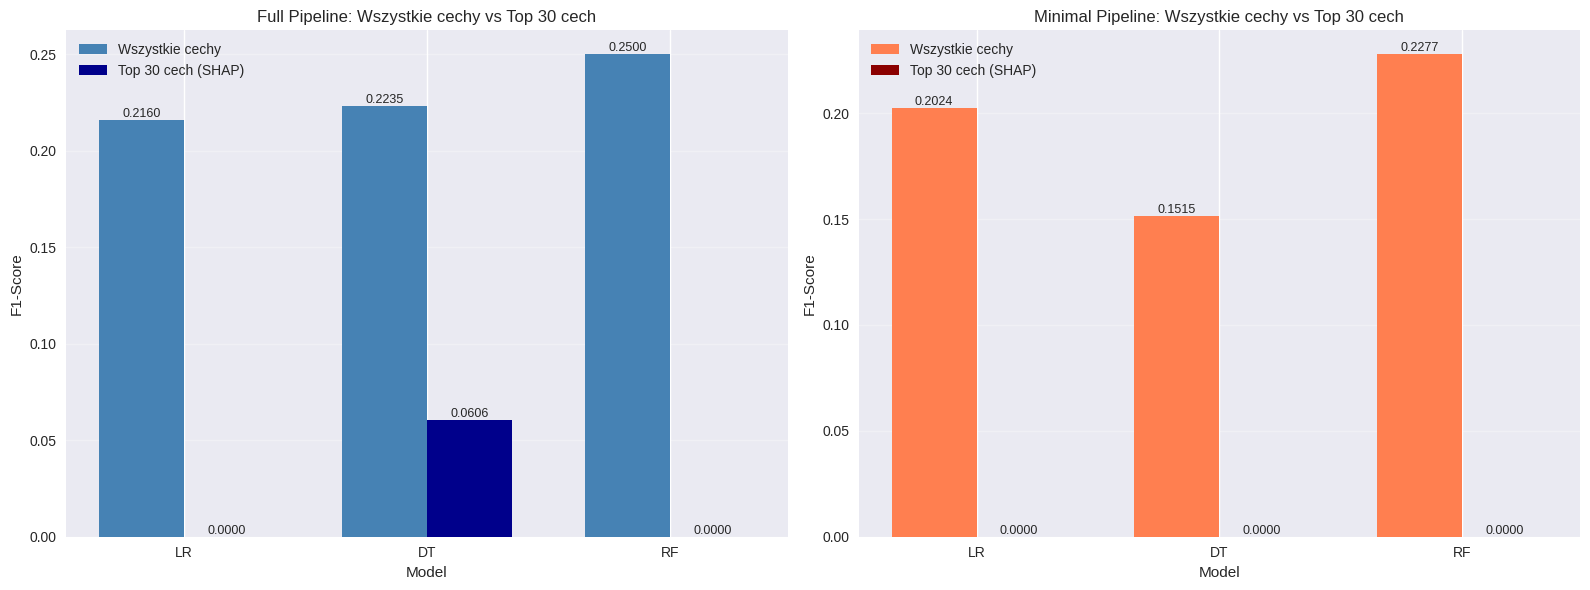


✅ Porównanie wyników zakończone.


In [198]:
# Porównanie wyników: Wszystkie cechy vs Top 30 cech
print("="*100)
print("PORÓWNANIE: WSZYSTKIE CECHY VS TOP 30 CECH")
print("="*100)

# Przygotowanie danych do porównania
comparison_data_top30 = []

# FULL PIPELINE
if len(full_top30_features) > 0:
    # Wszystkie cechy Full
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'All',
        'Model': 'LR',
        'F1-Score': results_full['LR']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'All',
        'Model': 'DT',
        'F1-Score': results_full['DT']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'All',
        'Model': 'RF',
        'F1-Score': results_blackbox_full['RF']['f1']
    })
    
    # Top 30 Full
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'Top30',
        'Model': 'LR',
        'F1-Score': results_full_top30['LR']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'Top30',
        'Model': 'DT',
        'F1-Score': results_full_top30['DT']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'Top30',
        'Model': 'RF',
        'F1-Score': results_full_top30['RF']['f1']
    })

# MINIMAL PIPELINE
if len(minimal_top30_features) > 0:
    # Wszystkie cechy Minimal
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'All',
        'Model': 'LR',
        'F1-Score': results_minimal['LR']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'All',
        'Model': 'DT',
        'F1-Score': results_minimal['DT']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'All',
        'Model': 'RF',
        'F1-Score': results_blackbox['RF']['f1']
    })
    
    # Top 30 Minimal
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'Top30',
        'Model': 'LR',
        'F1-Score': results_minimal_top30['LR']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'Top30',
        'Model': 'DT',
        'F1-Score': results_minimal_top30['DT']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'Top30',
        'Model': 'RF',
        'F1-Score': results_minimal_top30['RF']['f1']
    })

comparison_df_top30 = pd.DataFrame(comparison_data_top30)

# Wykres porównawczy
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Full Pipeline
full_data = comparison_df_top30[comparison_df_top30['Pipeline'] == 'Full']
x_labels = ['LR', 'DT', 'RF']
all_features_full = [full_data[(full_data['Model'] == m) & (full_data['Features'] == 'All')]['F1-Score'].values[0] 
                     for m in x_labels]
top30_features_full = [full_data[(full_data['Model'] == m) & (full_data['Features'] == 'Top30')]['F1-Score'].values[0] 
                       for m in x_labels]

x_pos = np.arange(len(x_labels))
width = 0.35

bars1 = axes[0].bar(x_pos - width/2, all_features_full, width, label='Wszystkie cechy', color='steelblue')
bars2 = axes[0].bar(x_pos + width/2, top30_features_full, width, label='Top 30 cech (SHAP)', color='darkblue')

axes[0].set_xlabel('Model')
axes[0].set_ylabel('F1-Score')
axes[0].set_title('Full Pipeline: Wszystkie cechy vs Top 30 cech')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(x_labels)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Dodanie wartości na słupkach
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Minimal Pipeline
minimal_data = comparison_df_top30[comparison_df_top30['Pipeline'] == 'Minimal']
all_features_minimal = [minimal_data[(minimal_data['Model'] == m) & (minimal_data['Features'] == 'All')]['F1-Score'].values[0] 
                        for m in x_labels]
top30_features_minimal = [minimal_data[(minimal_data['Model'] == m) & (minimal_data['Features'] == 'Top30')]['F1-Score'].values[0] 
                          for m in x_labels]

bars3 = axes[1].bar(x_pos - width/2, all_features_minimal, width, label='Wszystkie cechy', color='coral')
bars4 = axes[1].bar(x_pos + width/2, top30_features_minimal, width, label='Top 30 cech (SHAP)', color='darkred')

axes[1].set_xlabel('Model')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('Minimal Pipeline: Wszystkie cechy vs Top 30 cech')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(x_labels)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Dodanie wartości na słupkach
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✅ Porównanie wyników zakończone.")